# Fitting data for SST-wind coupling analysis (DMM and PA) depending on environmental conditions from MetOp A data and ERA5 to our simple model.
## Description

## To do's

## Details

@author: Lorenzo Francesco Davoli

@creation: 04/09/2025

@project: Phase-SST-wind-coupling

@github: https://github.com/lfdavoli/ASI_RS_MDPI

@contact: l.davoli@campus.unimib.it

@notes: 

# Packages, constants functions and controls

## Packages

In [ ]:
import sys
import os
import glob
import re
from pathlib import Path 
from tqdm import tqdm

# My utility funtions from "miscellanea" directory
from my_utility_functions import sym_log, weighted_linear_regression_with_pvalues, get_pandas_intervals_from_params, get_season
# Bulk fluxes and similia
from bulk_computations import compute_relative_humidity, compute_rescaled_wind, compute_specific_humidity, compute_virtual_temperature, compute_Obukhov_length, compute_air_density, compute_buoyancy_flux

import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats, optimize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')                   

import warnings
warnings.filterwarnings("ignore")


## Controls

In [ ]:
#############################
### SPACE AND TIME DOMAIN ###
#############################

# Period intervals
period_intervals = ['annual'] # or ['DJF','MAM','JJA','SON']

area_configs = [
    #{'area_str': 'extended_eureca', 'area_name': 'EUREC4A region', 'minlon': -62., 'maxlon': -40., 'minlat': 0, 'maxlat': 20., 'L_sst' : 80,'Gamma_stable' : 6.3e-2, 'Gamma_unstable' : 2.46e-2},
    #{'area_str': 'gulf_stream', 'area_name': 'Gulf Stream', 'minlon': -83., 'maxlon': -30., 'minlat': 30., 'maxlat': 55.,'L_sst' : 30,'Gamma_stable' : 6.25e-2, 'Gamma_unstable' : 4.923241975e-2,}, 
    #{'area_str': 'malvinas', 'area_name': 'Malvinas Current', 'minlon': -70., 'maxlon': 0., 'minlat': -60., 'maxlat': -30.,'L_sst' : 30,'Gamma_stable' : 7e-2, 'Gamma_unstable' : 5.9e-2,},
    #{'area_str': 'agulhas', 'area_name': 'Agulhas Current', 'minlon': 0., 'maxlon': 100., 'minlat': -60., 'maxlat': -30.,'L_sst' : 30,'Gamma_stable' : 7e-2, 'Gamma_unstable' : 5.58e-2,},
    #{'area_str': 'kuroshio', 'area_name': 'Kuroshio Current', 'minlon': 140., 'maxlon': 180., 'minlat': 30., 'maxlat': 50.,'L_sst' : 30,'Gamma_stable' : 6e-2, 'Gamma_unstable' : 5.51e-2,},
    #{'area_str': 'southern_indian', 'area_name': 'Southern Ocean', 'minlon': 55., 'maxlon': 100., 'minlat': -60., 'maxlat': -30.,'L_sst' : 30,'Gamma_stable' : 6.25e-2, 'Gamma_unstable' : 4.92324197435e-2,},
    #{'area_str': 'south_east_atlantic', 'area_name': 'Benguela Current', 'minlon': -10., 'maxlon': 15., 'minlat': -25., 'maxlat': -5., 'L_sst' : 60,'Gamma_stable' : 6.3e-2, 'Gamma_unstable' : 5.7e-2},
    #{'area_str': 'artic', 'area_name': 'Artic', 'minlon': -12., 'maxlon': 10., 'minlat': 67., 'maxlat': 75.50},
    #{'area_str': 'global', 'area_name': 'Global', 'minlon': -180., 'maxlon': 180., 'minlat': -60., 'maxlat': -60.},
    {'area_str': 'wbcs', 'area_name': 'WBCs', 'minlon': np.nan, 'maxlon': np.nan, 'minlat': np.nan, 'maxlat': np.nan,'L_sst' : 30,'Gamma_stable' : 6.25e-2, 'Gamma_unstable' : 4.923241975e-2,},
]
area_config = area_configs[0]

############################
### MECHANISM TO ANALYSE ###
############################

# Select here the fields to be analysed.
str_mech = 'DMM'
#str_mech = 'PA'

if str_mech == 'DMM':
    # DMM
    sst_deriv = 'dsst_dr' # Choose between: 'dsst_dr', 'lapl_sst', 'd2sst_ds2', 'sst_prime'
    sst_deriv_label = r"$\frac{\partial SST}{\partial dr}$"
    wind_deriv = 'dr_dot_prime_dr' # Choose between: 'wind_div', 'dr_dot_prime_dr', 'ds_dot_prime_ds', 'ws_prime'
    # Range of sst derivative
    #sst_deriv_range = [-5e-4,5e-4]

elif str_mech == 'PA':
    # PA
    sst_deriv = 'd2sst_ds2'
    wind_deriv = 'ds_dot_prime_ds'
    sst_deriv_label = r"$\frac{\partial SST}{\partial ds}$"
    #sst_deriv_range = [-2e-5,2e-5]
else:
    raise NameError('Mechanism not implemented')


#######################
### DATA DEFINITION ###
#######################

# Select the standard deviation of the Gaussian filter used to determine the background wind field.
# This is not used in the computation of the current script, but to select the correct field file
# amongst those already produced through "generate_fields_with_ERA5_wind_sst_derivatives.ipynb".
# If we take 5 the correlation seems to be less significant: we problably go to too fine scales... 
# Standard value: sigma = 10.
# In the tropics the SST structures are large: check how the results change for different sigmas.
sigma = 10
# Select the smoothing applied to the sst field through a gaussian filter.
psi = 2 # psi = 2 is the default value, allows to remove the noise without losing the fine scale.

# Select the smoothing to be applied to the wind field through a gaussian filter.
enable_wind_smoothing = False
if enable_wind_smoothing:
    sigma = 90 # *5km. 
    psi = 10 # *5km
    psi_wind = 10 # *5km
    if psi_wind != psi:
        raise NameError('Same SST-wind smoothing needed')
    if 5*psi_wind > sigma:
        raise NameError('No signal left for the anomaly field')

# Path to the files containing wind and SST derivative fields build through
# the script "generate_fields_with_ERA5_wind_sst_derivatives.ipynb". 
if enable_wind_smoothing:
    path2sst_wind_derivatives_output = '
else:
    path2sst_wind_derivatives_output = ''

##############################
### ANALYSES CONFIGURATION ###
##############################

# Tag indicating which version of the binning to use. Default: ''
tag = '_for_fit'

# Points to discard around the peak when fitting.
# 0 == include peak, 1 == exclude peak, 2 == exclude nearest neighbours, -1 == include one before the peak, etc
n_points_to_discard_low_U = 4 # from the peak backward
n_points_to_skip_low_U = 0 # from 0 onward
n_points_to_discard_high_U = 0 

# Remove outliers?
# If you don't remove outliers there are several non-linearity emerging.
enable_outliers_filter = False
# Percentile filter for outliers (applied at both extremes, so 2.5 == 2.5% to 97.5% accepted per variable it is applied to)
outliers_filter_percentile = 2.5

# Remove the central peak (wrt control variable) to compute the regressions 
# on the tails only, without its influence?
# We might also remove the central peak to speed-up the computation.
# With 90% still we have plenty of point to compute the statistics in the central bins.
enable_remove_central_peak = False
# Percentile of central data to be removed (%)
percentile_removed_from_central_peak = 90

# Filters points with low background wind, as Owen should have ruled them out
enable_low_background_wind_filter = False
low_background_wind_threshold = 4 #(m/s)

# Type of error to be associated to the control bin mean responses
control_bin_error = 'sem' # or 'std'

# Use percentiles control bins?
enable_percentile_control_bins = False
if enable_percentile_control_bins:
    perc = 5 # [%]
else:    
    # Number of bins to use in the binning of the control fields 
    # before computing the linear regression.
    n_control_bins = 20
    # Define explicitely the control bins
    #control_bins_ar = pd.interval_range(start=sst_deriv_range[0],end=sst_deriv_range[1],periods=20)
    #control_bins_ar = pd.interval_range(start=sst_deriv_range[0],end=sst_deriv_range[1],periods=20)
    # Include the external domain. Be careful, they can alter statistics
    #control_bins_ar = control_bins_ar.append(pd.IntervalIndex.from_tuples([(-np.inf,sst_deriv_range[0]),(sst_deriv_range[1],np.inf)])).sort_values()

# Minimum number of points inside a control bin to be accepted in the computation
# of the linear regression.
# If we are considering the coloc with SAR we do not have much data, so we lower the
# quality requirement when binning the control variable in the background ws
# analysis. On the other hand, the log_L analysis is always colocated, and therefore
# we keep a low control_bin_n_points_threshold_log_L.
min_n_points_control_bin = 100

# Reject regressions with R < R_threshold
enable_R_threshold = True
R_threshold = 0.8
# Reject regressions when the lin regr in the 
# pos and neg SST grad domain have opposite sign
enable_pos_neg_lin_regr_test = False

# Define how many control_bins have to be present in order for the lin regression
# to be considered reliable. 
# Consider that "n_control_bins_threshold_log_L" has to be smaller (optimally by 2-3 units) 
# than "control_bins".
# As the data are norm distributed, this is also an indirect control
# on the minimum range of env values to be covered.
min_n_control_bins = 10

# Reload binned data
resume_binning = False
reload_binned_data = True
if reload_binned_data or resume_binning:
    if enable_wind_smoothing:
        binned_data_file = ''
    else:
        binned_data_file = ''

################################
### ENVIRONMENTAL CONDITIONS ###
################################

# Environmental conditions to use in the binning of the data.
env_conds = [
    'background_ws',
    'rescaled_background_ws',
    'air_sea_temp_diff_era5',
    'asc',
]

# Columns to extract from fields file
cols_to_extract = [
    'control',
    'response',
    ]

if 'background_ws' in env_conds:
    cols_to_extract.append('background_ws')
if 'rescaled_background_ws' in env_conds:
    cols_to_extract.extend(['background_ws','lat'])
if 'air_sea_temp_diff_era5' in env_conds:
    cols_to_extract.extend(['t2m_era5','sst_era5'])
if 'asc' in env_conds:
    cols_to_extract.extend(['asc'])
cols_to_extract = list(set(cols_to_extract))

# Define classes for each env condition
env_conds_classes = {
    'background_ws' : {
        'bins' : get_pandas_intervals_from_params(0,22,11,extend_to_neg_inf=False),
        'attrs' : {
            'unit' : 'm s-1',
        },
    },
    'rescaled_background_ws' : {
        'bins' : get_pandas_intervals_from_params(0,22,11,extend_to_neg_inf=False),
        'attrs' : {
            'unit' : 'm s-1',
        },
    },
    'air_sea_temp_diff_era5' : {
        'bins' : get_pandas_intervals_from_params(-15,5,10),
        'attrs' : {
            'unit' : 'K',
        },
    },
    'asc' : {
        'bins' : pd.IntervalIndex.from_tuples([(-0.5,0.5),(0.5,1.5)]),
        'attrs' : {
            'unit' : 'bool',
        },
    },
}


###############
### UTILITY ###
###############

enable_debug_mode = False
enable_debug_plot = enable_debug_mode & False


#####################
### PLOT SETTINGS ###
#####################

enable_plot = True
plot_n_points_in_2Denvcond_graph = False

# Environmental conditions to consider for the 2D heatmaps
# format [ [x_axis_map1, y_axis_map1] , [ _map2_ ] , [ _map3_ ] ]
env_conds_2D = [
    [
        'air_sea_temp_diff_era5',
        'background_ws',
    ],        
]

percentile_colorbar_formatter = ticker.ScalarFormatter(useMathText=True)
percentile_colorbar_formatter.set_scientific(True)
percentile_colorbar_formatter.set_powerlimits((-2, 2))

# Details on how to plot env conds
env_conds_plot_attrs = {
    'background_ws' : {
        'axis_label'    : 'U',
        'unit'          : '[m/s]',
    },
    'rescaled_background_ws' : {
        'axis_label'    : r'$U\cdot sin(\varphi)$',
        'unit'          : '[m/s]',
    },
    'log_L_ML_50' : {
        'axis_label'    : r'$log(L)_{ML}$',
        'unit'          : '',
    }, 
    'pos_log_L_era5' : {
        'axis_label'    : r'$log(L)_{ERA5}$, $L>0$',
        'unit'          : '',
    }, 
    'pos_log_L_coare_50' : {
        'axis_label'    : r'$log(L)_{COARE}$, $L>0$',
        'unit'          : '',
    }, 
    'neg_log_L_era5' : {
        'axis_label'    : r'$log(L)_{ERA5}$, $L<0$',
        'unit'          : '',
    },   
    'neg_log_L_coare_50' : {
        'axis_label'    : r'$log(L)_{COARE}$, $L<0$',
        'unit'          : '',
    }, 
    'air_sea_temp_diff_coare_50' : {
        'axis_label'    : '$T_{air}$-SST (coare)',
        'unit'          : '[K]',
    },
    'air_sea_temp_diff_era5' : {
        'axis_label'    : '$T^{air}_{ERA5}$-$SST_{ERA5}$',
        'unit'          : '[K]',
    },
    'usr_coare_50' : {
        'axis_label'    : '$u*_{coare}$',
        'unit'          : '[m/s]',
    },
    'hbb_coare_50' : {
        'axis_label'    : r'$B_{coare}$ = -$\rho$ $c_p$ $u_{*}$ $T_v$',
        'unit'          : '[]',
    },
    'slhf_era5' : {
        'axis_label'    : '$L_{ERA5}$',
        'unit'          : '[J $m^{-2}$]',
    },
    'sshf_era5' : {
        'axis_label'    : '$Q_{ERA5}$',
        'unit'          : '[J $m^{-2}$]',
    },
    'zust_era5' : {
        'axis_label'    : '$u*_{ERA5}$',
        'unit'          : '[m/s]',
    },
    'B_era5' : {
        'axis_label'    : '$B_{ERA5}$',
        'unit'          : '[$W$ $m^{-2}$]',
    },
    'B_ML_50' : {
        'axis_label'    : '$B_{ML}$',
        'unit'          : '[$W$ $m^{-2}$]',
    },
    'Q_B_era5' : {
        'axis_label'    : '$Q_{B,ERA5}$',
        'unit'          : '[$m^2$ $s^{-3}$]',
    },
    'L_B_era5' : {
        'axis_label'    : '$L_{B,ERA5}$',
        'unit'          : '[$m^2$ $s^{-3}$]',
    },
    'q_era5' : {
        'axis_label'    : '$q_{ERA5}$',
        'unit'          : '[g $kg^{-1}$]',
    },
    'log_L_coare_era5_ML_10' : {
        'axis_label'    : r'$log(L)_{ML}^{10km}$',
        'unit'          : '[-]',
    }, 
    'neg_log_L_coare_era5_ML_10' : {
        'axis_label'    : r'$log(L)_{ML}^{10km} \, , L_{COARE,ERA5}<0$',
        'unit'          : '[-]',
    }, 
    'pos_log_L_coare_era5_ML_10' : {
        'axis_label'    : r'$log(L)_{ML}^{10km} \, , L_{COARE,ERA5}>0$',
        'unit'          : '[-]',
    }, 
    'pos_log_L_coare_era5' : {
        'axis_label'    : r'$log(L)_{COARE,ERA5}$, $L>0$',
        'unit'          : '',
    }, 
    'neg_log_L_coare_era5' : {
        'axis_label'    : r'$log(L)_{COARE,ERA5}$, $L<0$',
        'unit'          : '',
    },
    'asc' : {
        'axis_label'    : 'Ascending orbit',
        'unit'          : '[bool]',
    },
}

# Typical coupl coeff extremes of the mechanism
# for symmetric 2D plots.  
if str_mech == 'DMM':
    lim_coupl_coeff = 0.4
elif str_mech == 'PA':
    lim_coupl_coeff = None #3000

# Plots labels
if sst_deriv=='gamma':
    sst_deriv_label = 'u.grad(SST) [K/s]'
elif sst_deriv=='dsst_dr':
    sst_deriv_label = r'$\partial SST/ \partial r$ [K/m]'
elif sst_deriv=='lapl_sst':
    sst_deriv_label = 'lapl SST [K/m^2]'
elif sst_deriv=='d2sst_ds2':
    sst_deriv_label = r'$\partial^2 SST/\partial s^2$ [K/m^2]'
elif sst_deriv=='sst_prime':
    sst_deriv_label = 'SST_prime [K]'

if wind_deriv=='wind_div':
    wind_deriv_label = 'Wind divergence [1/s]'
elif wind_deriv=='dr_dot_prime_dr':
    wind_deriv_label = r"$\partial u'_r/ \partial r$ [1/s]"
elif wind_deriv=='ds_dot_prime_ds':
    wind_deriv_label = r"$\partial u'_s/ \partial s$ [1/s]"
elif wind_deriv=='ws_prime':
    wind_deriv_label = 'ws_prime [m/s]'

if str_mech=='DMM':
    str_mech_unit='[m s$^{-1}$ K$^{-1}$]'
elif str_mech=='PA':
    str_mech_unit='[m$^2$ s$^{-1}$ K$^{-1}]$'

# Control files and figures saving
coupling_coeff_output_folder = ''
binned_data_output_folder = ''
enable_save_coup_curve_figures = False
figures_output_folder = ''
enable_save_coup_coeff_figures = False
enable_save_coup_coeff_2D = True
enable_save_coup_coeff_data = False
enable_save_binned_data = False

## Functions

In [3]:
def get_start_end_dates_from_filename(filename):
    match = re.search(r'from_(\d{4}-\d{2}-\d{2})_to_(\d{4}-\d{2}-\d{2})', filename)
    if match:
        return pd.to_datetime(match.groups()[0]),pd.to_datetime(match.groups()[1])
    else:
        raise NameError('No dates found')

def parse_interval(interval_str):
    # Handles intervals like '(a, b]', '[a, b)', etc.
    match = re.match(r'([\[\(])\s*([-\d\.e]+|inf|-inf),\s*([-\d\.e]+|inf|-inf)\s*([\]\)])', interval_str)    
    if not match:
        raise ValueError(f"Cannot parse interval string: {interval_str}")
    left_bracket, left, right, right_bracket = match.groups()
    left = float(left)
    right = float(right)
    closed = None
    if left_bracket == '[' and right_bracket == ']':
        closed = 'both'
    elif left_bracket == '(' and right_bracket == ']':
        closed = 'right'
    elif left_bracket == '[' and right_bracket == ')':
        closed = 'left'
    elif left_bracket == '(' and right_bracket == ')':
        closed = 'neither'
    return pd.Interval(left, right, closed=closed)

def reload_binned_data_ds(filepath, env_conds, control_name='control'):
    ds = xr.open_dataset(filepath)
    for var in env_conds + [control_name]:
        if ds[var].dtype == object or ds[var].dtype.str.startswith('|S') or ds[var].dtype.str.startswith('<U'):
            intervals = [parse_interval(s) for s in ds[var].values]
            ds = ds.assign_coords({var: intervals})
    return ds

def compute_statistic(df:pd.DataFrame,statistic:str):
    if statistic == 'n_points':
        return len(df)
    elif statistic == 'sum_control':
        return sum(df['control'])
    elif statistic == 'sum_response':
        return sum(df['response'])
    elif statistic == 'sum_response_pow2':
        return sum(np.power(df['response'],2))
    elif statistic == 'sum_control_pow2':
        return sum(np.power(df['control'],2))
    elif statistic == 'sum_control_response':
        return sum(np.multiply(df['control'],df['response']))

def get_bins_statistics_from_df(df : pd.DataFrame, orig_nesting : dict, binned_data_ds : xr.Dataset) -> tuple:
    '''
    Split recursively df according to the binning defined in binned_data_ds.
    The information regarding dimensions which have already been split is
    contained in "current_nesting".
    Find a 1-dimensional subset of the original "df" corresponding to a point in the 
    n_env_conds-dimensional state space of env_conds.
    At this point, compute the statistics defined as data_vars in "binned_data_ds", 
    sum it to the corrisponding cell in "binned_data_ds", and return its arguments.
    '''

    # Be sure of using a copy so they don't get updated by mistake.
    nesting = orig_nesting.copy()

    if enable_debug_mode:
        print('\n ### Recursion ###')
        print(f"\t Dataframe size : {len(df)}")
        print(nesting)

    if sorted(list(nesting.keys())) == sorted(list(binned_data_ds.coords)):
        # If we have split along all dimensions already we can proceed 
        # updating the statistics.
        for statistic in binned_data_ds.data_vars:
            if enable_debug_mode:
                print(f"\t Save statistic {statistic}, current val = {str(binned_data_ds[statistic].sel(nesting).data)}, increase = {str(compute_statistic(df,statistic))}")
            # Increment the statistic
            binned_data_ds[statistic].loc[nesting] += compute_statistic(df,statistic)

        if enable_debug_mode:
            print("\t DONE\n")

        return df,nesting,binned_data_ds
    
    # Find next variable to split
    split_vars = [var for var in binned_data_ds.coords if var not in nesting]
    for var in split_vars:
        if enable_debug_mode:
            print(f"\t Var = {var}")
        if var not in df.columns or var == 'response':
            # The response is not in the phase-space so we 
            # don't split along it.
            if enable_debug_mode:
                print(f"\t\t {var} skip")
            continue
        # Variable still to split, proceed to do so.
        # Use pd.cut for binning, groupby for efficiency
        bins = binned_data_ds.coords[var].data
        cut = pd.cut(df[var], bins)
        for interval, group_df in df.groupby(cut,observed=True):
            if enable_debug_mode:
                print(f"\t\t {var} -> {str(interval)}")
            if group_df.empty:
                if enable_debug_mode:
                    print(f"\t\t {var} -> {str(interval)} : empty")
                continue
            nesting[var] = interval
            # Call the function again to continue the splitting.
            # We want to catch the returned binned_data_ds and transfer 
            # back up while resolving the recursion.
            _,_,binned_data_ds = get_bins_statistics_from_df(group_df, nesting, binned_data_ds)
            del group_df
        
        del bins, cut

        break
    return df,nesting,binned_data_ds


def add_variables(df:pd.DataFrame,variables:list) -> pd.DataFrame:
    for var in variables:
        if var in df.columns:
            continue
        elif var == 'rescaled_background_ws':
            df[var] = compute_rescaled_wind(df['background_ws'],df['lat'])
        elif var == 'air_sea_temp_diff_era5':
            df[var] = df['t2m_era5']-df['sst_era5']
        else:
            raise NameError(f'{var} computation not implemented')
        
    return df

# Pre-processing 

## List of files

In [4]:
if area_config['area_str'] != 'wbcs':

    files = sorted(glob.glob(path2sst_wind_derivatives_output+'/*'))

    period_start = os.path.basename(files[0])[-41:-31]
    period_end = os.path.basename(files[-1])[-27:-17]

    files

## Create container for binned data

In [ ]:
if area_config['area_str'] == 'wbcs':
    # Open gulf_stream as container for all WBCs, sum values
    if enable_wind_smoothing:
        binned_data_file = ''
    else:
        binned_data_file = ''

    wbcs_binned_data_ds = xr.open_dataset(binned_data_file)
    
    # Convert string coordinates back to pandas.Interval for all relevant variables
    for var in wbcs_binned_data_ds.coords:
        if str(wbcs_binned_data_ds[var].dtype).startswith('<U') and var != 'period_interval':
            intervals = [parse_interval(s) for s in wbcs_binned_data_ds[var].values]
            wbcs_binned_data_ds = wbcs_binned_data_ds.assign_coords({var: intervals})
    
    for area_str in ['agulhas','malvinas','kuroshio']:
        if enable_wind_smoothing:
            binned_data_file = ''
        else:
            binned_data_file = ''

        binned_data_ds = xr.open_dataset(binned_data_file)
        
        # Convert string coordinates back to pandas.Interval for all relevant variables
        for var in binned_data_ds.coords:
            if str(binned_data_ds[var].dtype).startswith('<U') and var != 'period_interval':
                intervals = [parse_interval(s) for s in binned_data_ds[var].values]
                binned_data_ds = binned_data_ds.assign_coords({var: intervals})
        
        #wbcs_binned_data_ds[var], binned_data_ds[var] = xr.align(wbcs_binned_data_ds[var], binned_data_ds[var], join='inner')

        for var in binned_data_ds.data_vars:
            wbcs_binned_data_ds[var].data = wbcs_binned_data_ds[var].data + binned_data_ds[var].data
    
    binned_data_ds = wbcs_binned_data_ds
        
        
elif resume_binning:
    binned_data_ds = reload_binned_data_ds(binned_data_file,env_conds)
else:
    # Create coordinates container for the xarray.Dataset
    coords = dict(
        period_interval=('period_interval',period_intervals),
    )

    # Define dimensions for env conds
    for var in env_conds:
        coords[var] = (var,env_conds_classes[var]['bins'])

    # Add control bins 
    df_ar = []
    for filename in files[::100]:
        df = pd.read_csv(filename, index_col=None, header=0)
        df_ar.append(df)

    df = pd.concat(df_ar, axis=0, ignore_index=True)

    if enable_percentile_control_bins:
        edges = [-np.inf]
        edges.extend(list(np.percentile(df['control'],np.arange(0,100,perc))))
        edges.append(np.inf)
        control_bins_ar = pd.IntervalIndex.from_arrays(left=edges[:-1],right=edges[1:])
        del df_ar,df,edges
    else:
        # Compute proper uniform binning from subset of data
        edges = [-np.inf]
        edges.extend(pd.cut(
            df['control'],
            n_control_bins,
            retbins=True)[1])
        edges.append(np.inf)
        control_bins_ar = pd.IntervalIndex.from_arrays(left=edges[:-1],right=edges[1:])
        del df_ar,df,edges
    coords['control'] = ('control',control_bins_ar)

    # Create a container for all the binned data
    binned_data_ds = xr.Dataset(
        coords=coords
    )
    # Add attributes
    binned_data_ds['control'] = binned_data_ds['control'].assign_attrs({'name' : sst_deriv})
    for var in env_conds:
        binned_data_ds[var] = binned_data_ds[var].assign_attrs(env_conds_classes[var]['attrs'])

    # Add a variable with all zero values
    for var in ['n_points','sum_control','sum_response','sum_response_pow2','sum_control_pow2','sum_control_response']:
        binned_data_ds[var] = xr.DataArray(
            data=np.zeros([dim for dim in binned_data_ds.dims.values()]),  # Create an array of zeros with the shape of the dataset
            dims=binned_data_ds.dims.keys(),  # Use the dimensions of the dataset
            coords=binned_data_ds.coords,  # Use the coordinates of the dataset
            attrs={}  # Optional: Add metadata
    )
binned_data_ds

<xarray.Dataset> Size: 14MB
Dimensions:                 (period_interval: 1, background_ws: 45,
                             rescaled_background_ws: 12,
                             air_sea_temp_diff_era5: 12, asc: 2, control: 22)
Coordinates:
  * period_interval         (period_interval) <U6 24B 'annual'
  * background_ws           (background_ws) object 360B (0.0, 0.5] ... (22.0,...
  * rescaled_background_ws  (rescaled_background_ws) object 96B (0.0, 2.0] .....
  * air_sea_temp_diff_era5  (air_sea_temp_diff_era5) object 96B (-inf, -15.0]...
  * asc                     (asc) object 16B (-0.5, 0.5] (0.5, 1.5]
  * control                 (control) object 176B (-inf, -0.00029983725046940...
Data variables:
    n_points                (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control             (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_response            (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_response_pow2       (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control_pow2        (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control_response    (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
Attributes:
    last_added_file:  /pacific/data_lorenzo/sst_wind_derivatives_fields_outpu...

# Data extraction and binning

## Extract new database

In [6]:
if area_config['area_str'] == 'wbcs':
    print('Overwritten')
elif resume_binning:
    # Continue to add the info starting from the last day added to
    # the reloaded binned database. 
    last_added_file = binned_data_ds.attrs['last_added_file']
    # Find date corresponding to the last day added to the
    # reloaded binned database. 
    match = re.search(r'from_(\d{4}-\d{2}-\d{2})_to_(\d{4}-\d{2}-\d{2})', last_added_file)
    if match:
        last_added_file_end_dt = pd.to_datetime(match.groups()[1])
    else: 
        raise NameError('Last added day not recognised')
    
    # Keep only files from the last added onward
    files_start_dt = [get_start_end_dates_from_filename(os.path.basename(file))[0] for file in files]
    files = [ file for i,file in enumerate(files) if files_start_dt[i] > last_added_file_end_dt]
elif reload_binned_data:
    print(binned_data_file)
    binned_data_ds = xr.open_dataset(binned_data_file)
    
    # Convert string coordinates back to pandas.Interval for all relevant variables
    for var in binned_data_ds.coords:
        if str(binned_data_ds[var].dtype).startswith('<U') and var != 'period_interval':
            intervals = [parse_interval(s) for s in binned_data_ds[var].values]
            binned_data_ds = binned_data_ds.assign_coords({var: intervals})

if not reload_binned_data:
    if len(files) != 0:        
        period_start = os.path.basename(files[0])[-41:-31]
        period_end = os.path.basename(files[-1])[-27:-17]

        for file in tqdm(files,total=len(files)):
            if enable_debug_mode: print(os.path.basename(file))
            
            if period_intervals == ['annual']:
                nesting = {'period_interval' : 'annual'}
            else:
                season = get_season([
                    pd.to_datetime(os.path.basename(file)[-41:-31],utc=True),
                    pd.to_datetime(os.path.basename(file)[-27:-17],utc=True)
                    ])
                #for period_intervals:
                nesting = {'period_interval' : season}

            df = pd.read_csv(file,usecols=cols_to_extract)
            
            if enable_remove_central_peak:
                df = df.loc[
                    (df.control < np.percentile(df.control,(100-percentile_removed_from_central_peak)/2)) |
                    (df.control > np.percentile(df.control,(100+percentile_removed_from_central_peak)/2))  
                    ]
                df.reset_index(drop=True)
                
            # Crop df file here if only a specific region is needed

            # Add env cond from bulk computations
            df = add_variables(df,env_conds)

            # Drop useless columns
            cols_to_keep = env_conds + ['control', 'response']
            df = df[cols_to_keep]

            # Drop nans
            df.dropna(inplace=True)

            # Real computation
            _,_,binned_data_ds = get_bins_statistics_from_df(df,nesting,binned_data_ds)

            if enable_save_binned_data:
                if enable_debug_mode: print('Saving binned data')
                adapted_binned_data_ds = binned_data_ds.copy()
                # Save current status
                adapted_binned_data_ds.attrs = dict(last_added_file=file)
                # Convert Interval coordinates to strings for all relevant variables
                for var in env_conds + ['control']:
                    if np.issubdtype(adapted_binned_data_ds[var].dtype, np.object_):
                        adapted_binned_data_ds = adapted_binned_data_ds.assign_coords(
                            {var: [str(interval) for interval in adapted_binned_data_ds[var].values]}
                        )
                # Ensure the dir is there
                Path(os.path.join(
                        binned_data_output_folder, 
                        os.path.basename(files[0])[:-27] + os.path.basename(files[-1])[-27:-4] + '_binned_data'
                    )).mkdir(parents=True,exist_ok=True)
                adapted_binned_data_ds.to_netcdf(os.path.join(
                    binned_data_output_folder,
                    os.path.basename(files[0])[:-27] + os.path.basename(files[-1])[-27:-4] + '_binned_data',
                    os.path.basename(files[0])[:-27] + os.path.basename(files[-1])[-27:-4] + f'_binned_data_perc_bins_{enable_percentile_control_bins}.nc'
                    ))
                del adapted_binned_data_ds
                if enable_debug_mode: 
                    print(f"N_points : {binned_data_ds['n_points'].data.sum()}")
                    print('Saving binned data - DONE')

            del df

    print(binned_data_ds)
    print(f"N_points : {binned_data_ds['n_points'].data.sum()}")


Overwritten


In [7]:
binned_data_ds

<xarray.Dataset> Size: 14MB
Dimensions:                 (period_interval: 1, background_ws: 45,
                             rescaled_background_ws: 12,
                             air_sea_temp_diff_era5: 12, asc: 2, control: 22)
Coordinates:
  * period_interval         (period_interval) <U6 24B 'annual'
  * background_ws           (background_ws) object 360B (0.0, 0.5] ... (22.0,...
  * rescaled_background_ws  (rescaled_background_ws) object 96B (0.0, 2.0] .....
  * air_sea_temp_diff_era5  (air_sea_temp_diff_era5) object 96B (-inf, -15.0]...
  * asc                     (asc) object 16B (-0.5, 0.5] (0.5, 1.5]
  * control                 (control) object 176B (-inf, -0.00029983725046940...
Data variables:
    n_points                (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control             (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_response            (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_response_pow2       (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control_pow2        (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control_response    (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
Attributes:
    last_added_file:  /pacific/data_lorenzo/sst_wind_derivatives_fields_outpu...

## Remove +/- inf bins

In [8]:
if False and enable_percentile_control_bins: 
    # Rimuovi infinite bins
    selected_bins = slice(1,20)    
    # Rimuovi bin up to 90th percentile
    #selected_bins = slice(2,19)    
    binned_data_ds = binned_data_ds.isel(control=selected_bins)
    binned_data_ds

## Check distribution of points in bins

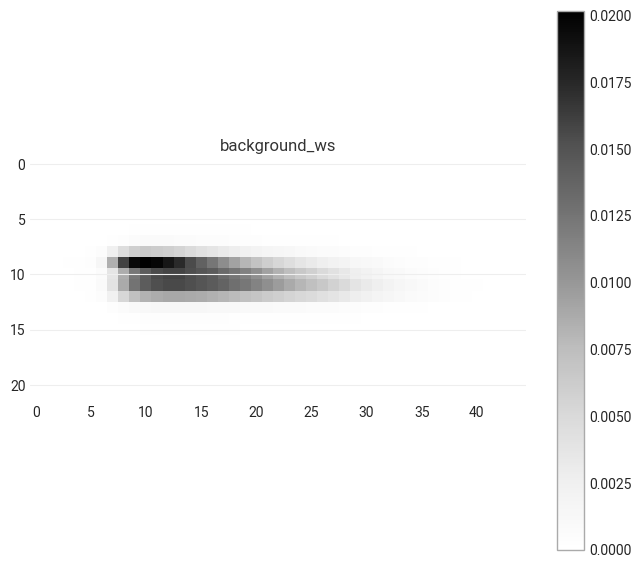

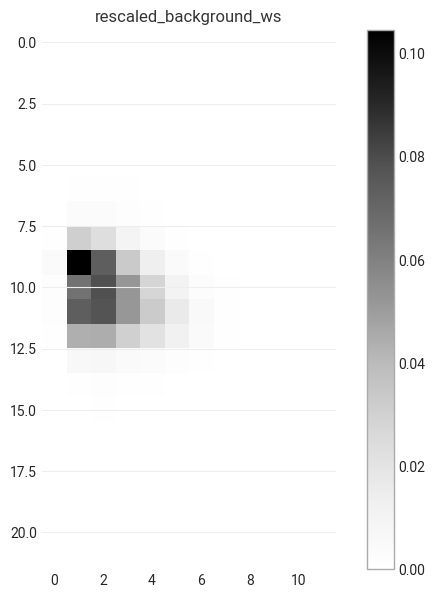

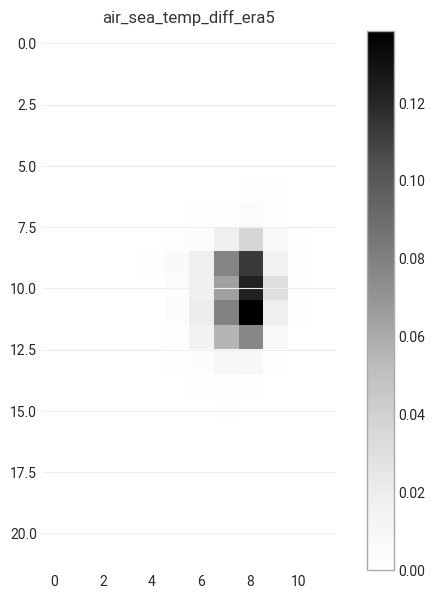

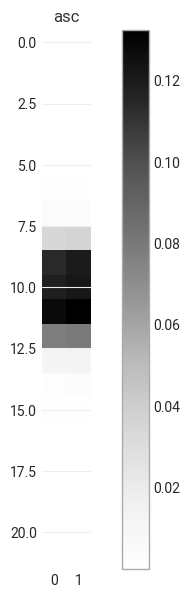

In [9]:
if enable_plot:
    norm=sum(binned_data_ds['n_points'].data.flatten())

    for env_cond in env_conds:
        # Container
        n_points_2D_distr = np.zeros(shape=(len(binned_data_ds['control'].data),len(binned_data_ds[env_cond].data)))
        
        for i,control_val in enumerate(binned_data_ds['control'].data):
            for j,env_cond_val in enumerate(binned_data_ds[env_cond].data):
                n_points_2D_distr[i,j] = binned_data_ds.isel(indexers={'control' : i, env_cond : j})['n_points'].sum()/norm    
            

        ims=plt.imshow(n_points_2D_distr,cmap='Greys')
        plt.colorbar(ims)
        plt.title(env_cond)
        plt.show()


# Coupling trends and fitting as a function of environmental conditions

In [10]:
try:
    orig_binned_data_ds
except:
    print('Copy binned_ds')
    orig_binned_data_ds = binned_data_ds.copy()

orig_binned_data_ds

Copy binned_ds


<xarray.Dataset> Size: 14MB
Dimensions:                 (period_interval: 1, background_ws: 45,
                             rescaled_background_ws: 12,
                             air_sea_temp_diff_era5: 12, asc: 2, control: 22)
Coordinates:
  * period_interval         (period_interval) <U6 24B 'annual'
  * background_ws           (background_ws) object 360B (0.0, 0.5] ... (22.0,...
  * rescaled_background_ws  (rescaled_background_ws) object 96B (0.0, 2.0] .....
  * air_sea_temp_diff_era5  (air_sea_temp_diff_era5) object 96B (-inf, -15.0]...
  * asc                     (asc) object 16B (-0.5, 0.5] (0.5, 1.5]
  * control                 (control) object 176B (-inf, -0.00029983725046940...
Data variables:
    n_points                (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control             (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_response            (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_response_pow2       (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control_pow2        (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
    sum_control_response    (period_interval, background_ws, rescaled_background_ws, air_sea_temp_diff_era5, asc, control) float64 2MB ...
Attributes:
    last_added_file:  /pacific/data_lorenzo/sst_wind_derivatives_fields_outpu...

## $log(-log(1-\frac{\alpha}{\Gamma U})) = a + b \cdot log(U) \\ a = log(cL_{SST}) \quad,\quad b=-\nu \quad , \quad \Gamma \,\text{a priori}$

background_ws = (0.0, 0.5]
[ 0.  0.  0.  2.  2.  0.  1.  8. 15. 51. 90. 31. 15.  2.  0.  0.  0.  0.
  0.  0.  0.  0.]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[  0.   0.   0.   0.   0.   4.   5.  10.  26. 114. 201. 169.  36.   8.
   0.   0.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[  0.   0.   0.   1.   4.   2.  12.  15. 154. 253. 397. 249.  98.  29.
   6.   1.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (1.0, 1.5] : not enoug

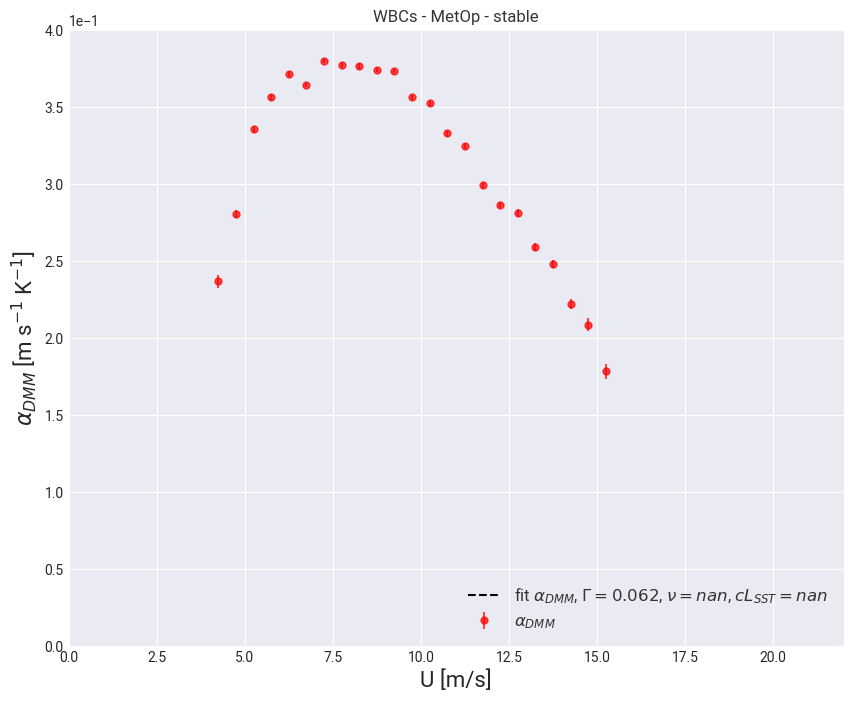

background_ws = (0.0, 0.5]
[0.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00 6.000e+00 1.500e+01
 7.100e+01 8.250e+02 2.606e+03 1.471e+03 1.832e+03 1.241e+03 3.290e+02
 1.020e+02 2.600e+01 1.000e+01 3.000e+00 2.000e+00 3.000e+00 0.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[0.000e+00 1.000e+00 2.000e+00 2.000e+00 1.400e+01 3.700e+01 6.900e+01
 3.190e+02 2.039e+03 6.304e+03 3.979e+03 5.128e+03 3.405e+03 7.600e+02
 1.950e+02 7.300e+01 1.600e+01 1.000e+01 6.000e+00 7.000e+00 3.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[0.0000e+00 1.0000e+00 3.0000e+00 8.0000e+00 2.2000e+01 4.0000e+01
 

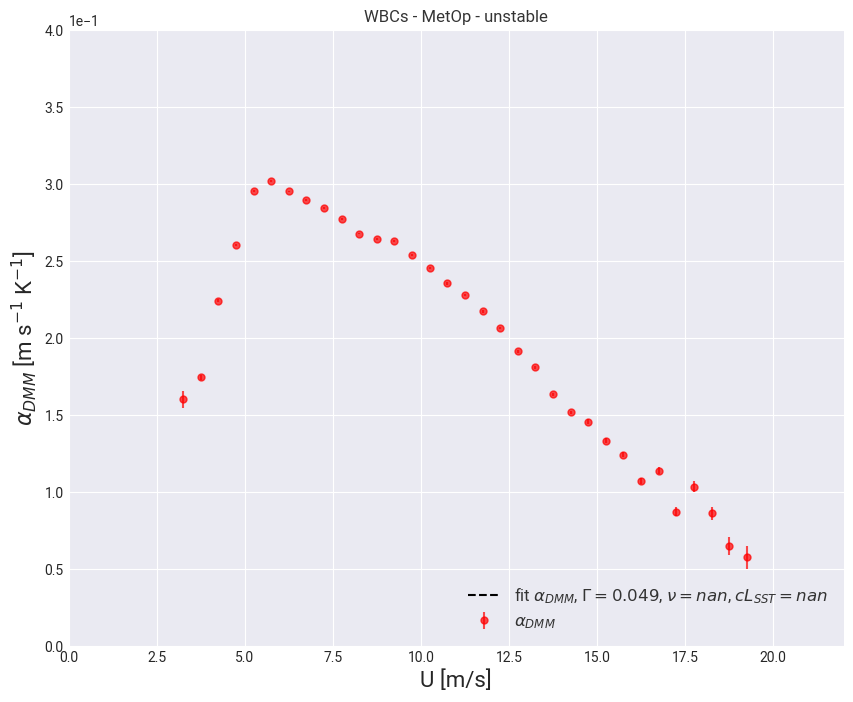

In [11]:
for atm_cond in ['stable','unstable']:

    # Select only the correct env cond
    if atm_cond == 'stable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left>=1])
    elif atm_cond == 'unstable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left<=-1])

    env_cond = 'background_ws'

    # Define the containers for each tuple (coeff,background_ws_bin,log_L_bin,radius)
    coeff_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    env_cond_bin_ar = []
    coeff_p_value_ar = []
    coeff_err_ar = []
    intercept_err_ar = []
    n_points_ar = []
    # Goodness of fit
    q_ar = []

    # Is the bin populated by entries belonging to the same SAR scene?
    #uniform_bin_ar = []

    for env_cond_bin,group_by_env_cond_bin in binned_data_ds.groupby(env_cond):
        print(f"{env_cond} = {env_cond_bin}")

        # Compute the appropriate statistics for the current selection of data.
        # It is equivalent to project the 4 variables onto the env_cond axis.
        statistics_dict = dict()
        for statistic in group_by_env_cond_bin.data_vars:
            statistics_dict[statistic] = []
            for control_bin,group_ds in group_by_env_cond_bin.groupby('control'):
                statistics_dict[statistic].append(group_ds[statistic].sum().data)

        control_bin_ar = group_by_env_cond_bin['control'].data
        n_points_bin_ar = np.array(statistics_dict['n_points'])

        # Find which control bins have enough points to compute statistics
        enough_points_mask = [ n_points > min_n_points_control_bin  for n_points in n_points_bin_ar]
        # Check if there are enough control bins to perform the lin regr
        if sum(enough_points_mask) < min_n_control_bins:
            print(n_points_bin_ar)
            print(enough_points_mask)
            print(f"{env_cond} = {env_cond_bin} : not enough control bins")
            
            if False and enable_plot:
                if sum(enough_points_mask) == 0: continue
                # Compute control and response avg/errors and number of points for each control bin.
                n_points_bin_ar = n_points_bin_ar[enough_points_mask]
                mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
                mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
                err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]
                
            
                linreg_result = weighted_linear_regression_with_pvalues(
                mean_control_ar,
                mean_response_ar,
                err_response_ar
                )
                coeff = linreg_result['slope'][0]
                coeff_err = linreg_result['slope'][1]
                intercept = linreg_result['intercept'][0]
                intercept_err = linreg_result['intercept'][1]
                q = linreg_result['q']

                fig,ax = plt.subplots(figsize=(8,6)) 
                ax.errorbar(
                    mean_control_ar,
                    mean_response_ar, 
                    yerr=err_response_ar, 
                    fmt='rx',
                    )
                ax.set_xlabel(sst_deriv_label,fontsize=16)
                ax.set_ylabel(wind_deriv_label,fontsize=16)
                ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                ax.tick_params(axis='both', which='major', labelsize=14)
                
                # Add the lin regr for comparison
                # Calculate the corresponding y values
                y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                ax.plot(
                    mean_control_ar,
                    y_lin_regr,
                    label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                    color = 'red',
                    alpha = 0.5,
                )

                ax.legend()
                ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                ax.legend()
                plt.show()

            continue 
        
        # Compute control and response avg/errors and number of points for each control bin.
        n_points_bin_ar = n_points_bin_ar[enough_points_mask]
        mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
        mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
        err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]

        # In order to verify the linearity hp, we compute the naive linear regression
        # for positive and negative values of the control variable, and we
        # compare them. If they differ, then we plot the coupling curve and we reject
        # the env_cond_class
        if enable_pos_neg_lin_regr_test:
            print('Check linearity - pos/neg lin test')
            pos_mean_control_ar = [ c for c in mean_control_ar if c > 0]
            pos_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c > 0]
            neg_mean_control_ar = [ c for c in mean_control_ar if c < 0]
            neg_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c < 0]
            
            pos_naive_linreg_result = stats.linregress(
                pos_mean_control_ar,               
                pos_mean_response_ar
                )
            neg_naive_linreg_result = stats.linregress(
                neg_mean_control_ar,               
                neg_mean_response_ar
                )
            if pos_naive_linreg_result.slope*neg_naive_linreg_result.slope < 0:
                print(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} : Non-linear ')
                
                if False and enable_plot:
                    fig,ax = plt.subplots()            
                    ax.scatter(
                        pos_mean_control_ar,
                        pos_mean_response_ar, 
                        c='red',
                        )
                    ax.scatter(
                        neg_mean_control_ar,
                        neg_mean_response_ar, 
                        c='blue',
                        )
                    ax.set_xlabel(sst_deriv_label)
                    ax.set_ylabel(wind_deriv_label)
                    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}')
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    pos_y_lin_regr = np.multiply(pos_naive_linreg_result.slope*np.ones_like(pos_mean_control_ar),pos_mean_control_ar) + pos_naive_linreg_result.intercept*np.ones_like(pos_mean_control_ar)
                    ax.plot(
                        pos_mean_control_ar,
                        pos_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(pos_naive_linreg_result.slope)} ',
                        color = 'red',
                        alpha = 0.5,
                    )            
                    neg_y_lin_regr = np.multiply(neg_naive_linreg_result.slope*np.ones_like(neg_mean_control_ar),neg_mean_control_ar) + neg_naive_linreg_result.intercept*np.ones_like(neg_mean_control_ar)
                    ax.plot(
                        neg_mean_control_ar,
                        neg_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(neg_naive_linreg_result.slope)} ',
                        color = 'blue',
                        alpha = 0.5,
                    )
                    plt.show()
                continue


        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']


        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        naive_rvalue = naive_linreg_result.rvalue
            
        if enable_R_threshold:
            print(f'Check linearity - R^2 > {R_threshold}')
            if naive_rvalue**2 < R_threshold:
                print(f'Non-linear: reject R^2 = {naive_rvalue**2}')
                print(naive_linreg_result)
                if False and enable_plot:
                    fig,ax = plt.subplots(figsize=(8,6)) 
                    ax.errorbar(
                        mean_control_ar,
                        mean_response_ar, 
                        yerr=err_response_ar, 
                        fmt='rx',
                        )
                    ax.set_xlabel(sst_deriv_label,fontsize=16)
                    ax.set_ylabel(wind_deriv_label,fontsize=16)
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    ax.tick_params(axis='both', which='major', labelsize=14)
                    
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_lin_regr,
                        label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                        color = 'red',
                        alpha = 0.5,
                    )

                    y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_naive_lin_regr,
                        label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                        color = 'orange',
                        alpha = 0.5,
                    )
                    ax.legend()
                    
                    ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                    ax.legend()
                    plt.show()

                    if enable_save_coup_curve_figures:
                        raise NameError('Update')
                        fig.savefig(os.path.join(
                            coupling_coeff_output_folder,
                            f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                            bbox_inches="tight",
                            dpi=200
                            )
                    del fig,ax

                continue

        if False and enable_plot:
            fig,ax = plt.subplots(figsize=(8,6)) 
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                fmt='ro',
                )
            ax.set_xlabel(sst_deriv_label,fontsize=16)
            ax.set_ylabel(wind_deriv_label,fontsize=16)
            ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            ax.tick_params(axis='both', which='major', labelsize=14)
            
            # Add the lin regr for comparison
            # Calculate the corresponding y values
            y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_lin_regr,
                label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                color = 'red',
                alpha = 0.5,
            )

            y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_naive_lin_regr,
                label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                color = 'orange',
                alpha = 0.5,
            )
            ax.legend()
            
            ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
            ax.legend()
            plt.show()

            if enable_save_coup_curve_figures:
                raise NameError('Update')
                fig.savefig(os.path.join(
                    coupling_coeff_output_folder,
                    f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                    bbox_inches="tight",
                    dpi=200
                    )
            del fig,ax


        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        q_ar.append(q)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_bin_ar.append(env_cond_bin)
        n_points_ar.append(sum(n_points_bin_ar))

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            'coeff' : coeff_ar,
            'naive_coeff' : naive_coeff_ar,
            'coeff_err' : coeff_err_ar,
        #    'coeff_p_value' : coeff_p_value_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
            # 'sklearn_coeff' : sklearn_coeff_ar,
            env_cond+'_bin' : env_cond_bin_ar,
            'q' : q_ar,
            'n_points_bin' : n_points_ar,
        }
    )

    print('### Results ###')
    print(coupling_coeff_env_cond_distr_df)

    # Fit coupling coeff dependency on U
    
    Gamma = area_config['Gamma_'+atm_cond]

    U = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df['background_ws_bin']])
    #coup_coeff_term = np.log(np.abs(np.log(1-np.divide(coupling_coeff_env_cond_distr_df['coeff'],Gamma*U))))
    coup_coeff_term = np.log(-np.log(1-np.divide(coupling_coeff_env_cond_distr_df['coeff'],Gamma*U)))
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        np.log(U),               
        coup_coeff_term
    )
    
    nu = -fit_result.slope
    cL = np.exp(fit_result.intercept)

    print(rf'$\nu = {nu}$')
    print(rf'$cL = {cL}$')

    coup_coeff_fit = np.multiply(Gamma*U,(1-np.exp(-cL*np.power(U,-nu))))
    
    if True and enable_plot:
        fig,ax=plt.subplots(figsize=(10,8))
        ax.errorbar(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df.coeff,
            yerr = coupling_coeff_env_cond_distr_df.coeff_err,
            fmt = 'ro',
            ms=5,
            alpha = 0.7,
            label = rf'$\alpha_{{{str_mech}}}$',
            )
        ax.plot(
            U,
            coup_coeff_fit,
            linestyle='--',
            color = 'black',
            label = rf'fit $\alpha_{{{str_mech}}}$, $\Gamma = {"{:.2g}".format(Gamma)}$, $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(cL)}$',
            )

        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=16)
        ax.set_xlim((0,22))
        ax.set_ylim((0,lim_coupl_coeff))
        ax.grid(color='white')
        ax.set_ylabel(rf"$\alpha_{{{str_mech}}}$ {str_mech_unit}",fontsize=16)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.set_title(f'{area_config['area_name']} - MetOp - {atm_cond}')
        ax.legend(loc='lower right',fontsize=12)


        if False:
            # Plot info on the intercept value
            # Define a small offset to apply to the x axis so they do not overlap.
            # The offset has to be dep on the env cond in the xaxis.
            # Let's take it as 5% of the avg bin distance
            #ax2_offset = np.mean([ np.mean(env_cond_bin.left-env_cond_bin.right) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values ])*0.1
            ax2 = ax.inset_axes([0, 0.8, 1, 0.20], sharex=ax)
            #ax2 = ax.twinx()
            ax2.errorbar(
        #        [ np.mean([env_cond_bin.right,env_cond_bin.left])+ax2_offset for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                coupling_coeff_env_cond_distr_df.intercept*1e5,
                yerr = coupling_coeff_env_cond_distr_df.intercept_err*1e5,
                color = 'purple',
                fmt = 's',
                alpha = 0.3,
                ms=5,
                #label = rf'$intercept_{{{str_mech}}}$',
                )
            #ax2.legend(loc="lower right")
            ax2.yaxis.tick_right()
            ax2.set_ylabel('y0 '+str_mech_unit+'*1e5',fontsize=10)
            ax2.yaxis.set_label_position('right')
            ax2.spines.top.set_visible(False)
            ax2.patch.set_alpha(0)

        plt.show()
        
        if enable_save_coup_coeff_figures:
            raise NameError('Update')
            fig.savefig(os.path.join(
                coupling_coeff_output_folder,
                f"coup_coeff_plot_{env_cond}_{database}_{file2read[:-4]}.png"),
                bbox_inches="tight",
                dpi=200
                )
        try: 
            del ax2,fig,ax
        except NameError:
            del fig,ax


    if enable_save_coup_coeff_data:
        print(f"Saving coupling coefficient {env_cond}")
        Path(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}').mkdir(parents=True, exist_ok=True)
        coupling_coeff_env_cond_distr_df.to_csv(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}'+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}_coup_coeff_vs_'+env_cond+'.txt')

## $\alpha = a + b \cdot U \quad , \quad a = \alpha_0 \quad, \quad b = \Gamma \quad \text{for} \quad U \to 0$
## $log(\alpha-\alpha_0) = a + b \cdot log(U) \quad , \quad a = log(cL_{SST}) \quad,\quad b=1-\nu \quad \text{for} \quad U \to \inf$

background_ws = (0.0, 0.5]
[ 0.  0.  0.  2.  2.  0.  1.  8. 15. 51. 90. 31. 15.  2.  0.  0.  0.  0.
  0.  0.  0.  0.]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[  0.   0.   0.   0.   0.   4.   5.  10.  26. 114. 201. 169.  36.   8.
   0.   0.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[  0.   0.   0.   1.   4.   2.  12.  15. 154. 253. 397. 249.  98.  29.
   6.   1.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (1.0, 1.5] : not enoug

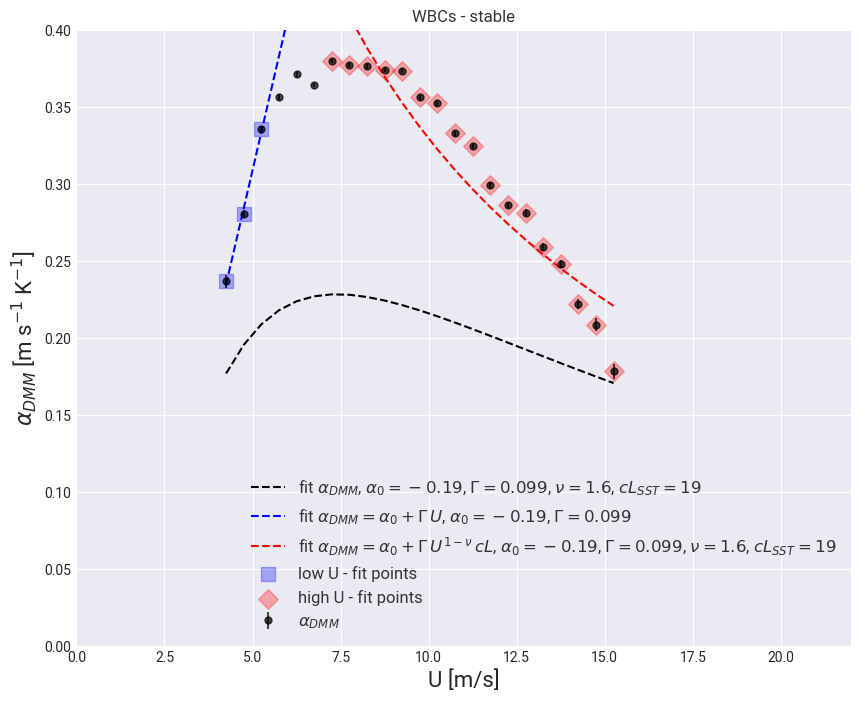

background_ws = (0.0, 0.5]
[0.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00 6.000e+00 1.500e+01
 7.100e+01 8.250e+02 2.606e+03 1.471e+03 1.832e+03 1.241e+03 3.290e+02
 1.020e+02 2.600e+01 1.000e+01 3.000e+00 2.000e+00 3.000e+00 0.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[0.000e+00 1.000e+00 2.000e+00 2.000e+00 1.400e+01 3.700e+01 6.900e+01
 3.190e+02 2.039e+03 6.304e+03 3.979e+03 5.128e+03 3.405e+03 7.600e+02
 1.950e+02 7.300e+01 1.600e+01 1.000e+01 6.000e+00 7.000e+00 3.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[0.0000e+00 1.0000e+00 3.0000e+00 8.0000e+00 2.2000e+01 4.0000e+01
 

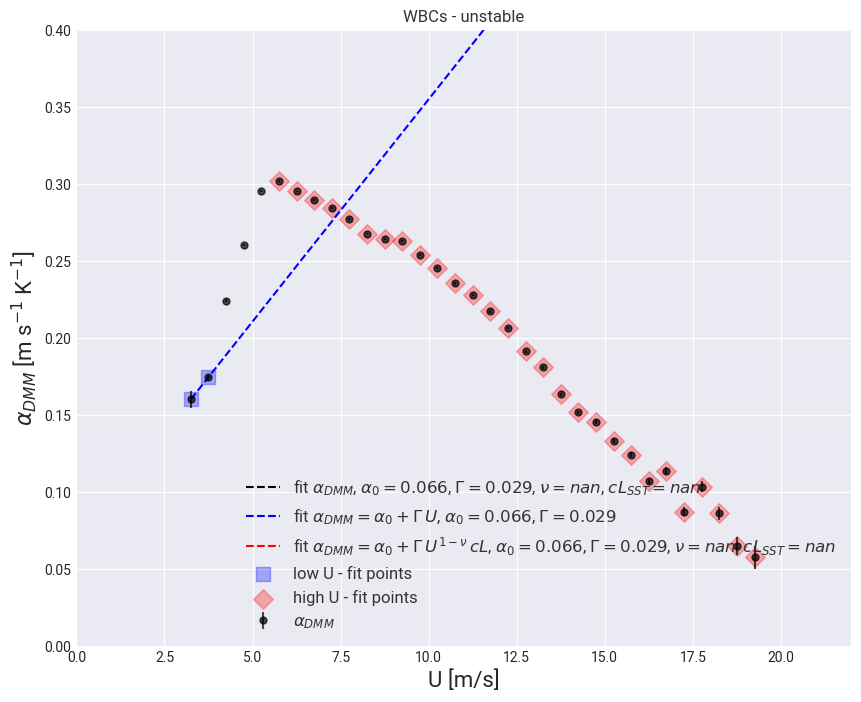

In [12]:
for atm_cond in ['stable','unstable']:

    # Select only the correct env cond
    if atm_cond == 'stable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left>=1])
    elif atm_cond == 'unstable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left<=-1])

    env_cond = 'background_ws'

    # Define the containers for each tuple (coeff,background_ws_bin,log_L_bin,radius)
    coeff_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    env_cond_bin_ar = []
    coeff_p_value_ar = []
    coeff_err_ar = []
    intercept_err_ar = []
    n_points_ar = []
    # Goodness of fit
    q_ar = []

    # Is the bin populated by entries belonging to the same SAR scene?
    #uniform_bin_ar = []

    for env_cond_bin,group_by_env_cond_bin in binned_data_ds.groupby(env_cond):
        print(f"{env_cond} = {env_cond_bin}")

        # Compute the appropriate statistics for the current selection of data.
        # It is equivalent to project the 4 variables onto the env_cond axis.
        statistics_dict = dict()
        for statistic in group_by_env_cond_bin.data_vars:
            statistics_dict[statistic] = []
            for control_bin,group_ds in group_by_env_cond_bin.groupby('control'):
                statistics_dict[statistic].append(group_ds[statistic].sum().data)

        control_bin_ar = group_by_env_cond_bin['control'].data
        n_points_bin_ar = np.array(statistics_dict['n_points'])

        # Find which control bins have enough points to compute statistics
        enough_points_mask = [ n_points > min_n_points_control_bin  for n_points in n_points_bin_ar]
        # Check if there are enough control bins to perform the lin regr
        if sum(enough_points_mask) < min_n_control_bins:
            print(n_points_bin_ar)
            print(enough_points_mask)
            print(f"{env_cond} = {env_cond_bin} : not enough control bins")
            
            if False and enable_plot:
                if sum(enough_points_mask) == 0: continue
                # Compute control and response avg/errors and number of points for each control bin.
                n_points_bin_ar = n_points_bin_ar[enough_points_mask]
                mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
                mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
                err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]
                
            
                linreg_result = weighted_linear_regression_with_pvalues(
                mean_control_ar,
                mean_response_ar,
                err_response_ar
                )
                coeff = linreg_result['slope'][0]
                coeff_err = linreg_result['slope'][1]
                intercept = linreg_result['intercept'][0]
                intercept_err = linreg_result['intercept'][1]
                q = linreg_result['q']

                fig,ax = plt.subplots(figsize=(8,6)) 
                ax.errorbar(
                    mean_control_ar,
                    mean_response_ar, 
                    yerr=err_response_ar, 
                    fmt='rx',
                    )
                ax.set_xlabel(sst_deriv_label,fontsize=16)
                ax.set_ylabel(wind_deriv_label,fontsize=16)
                ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                ax.tick_params(axis='both', which='major', labelsize=14)
                
                # Add the lin regr for comparison
                # Calculate the corresponding y values
                y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                ax.plot(
                    mean_control_ar,
                    y_lin_regr,
                    label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                    color = 'red',
                    alpha = 0.5,
                )

                ax.legend()
                ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                ax.legend()
                plt.show()

            continue 
        
        # Compute control and response avg/errors and number of points for each control bin.
        n_points_bin_ar = n_points_bin_ar[enough_points_mask]
        mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
        mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
        err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]

        # In order to verify the linearity hp, we compute the naive linear regression
        # for positive and negative values of the control variable, and we
        # compare them. If they differ, then we plot the coupling curve and we reject
        # the env_cond_class
        if enable_pos_neg_lin_regr_test:
            print('Check linearity - pos/neg lin test')
            pos_mean_control_ar = [ c for c in mean_control_ar if c > 0]
            pos_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c > 0]
            neg_mean_control_ar = [ c for c in mean_control_ar if c < 0]
            neg_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c < 0]
            
            pos_naive_linreg_result = stats.linregress(
                pos_mean_control_ar,               
                pos_mean_response_ar
                )
            neg_naive_linreg_result = stats.linregress(
                neg_mean_control_ar,               
                neg_mean_response_ar
                )
            if pos_naive_linreg_result.slope*neg_naive_linreg_result.slope < 0:
                print(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} : Non-linear ')
                
                if False and enable_plot:
                    fig,ax = plt.subplots()            
                    ax.scatter(
                        pos_mean_control_ar,
                        pos_mean_response_ar, 
                        c='red',
                        )
                    ax.scatter(
                        neg_mean_control_ar,
                        neg_mean_response_ar, 
                        c='blue',
                        )
                    ax.set_xlabel(sst_deriv_label)
                    ax.set_ylabel(wind_deriv_label)
                    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}')
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    pos_y_lin_regr = np.multiply(pos_naive_linreg_result.slope*np.ones_like(pos_mean_control_ar),pos_mean_control_ar) + pos_naive_linreg_result.intercept*np.ones_like(pos_mean_control_ar)
                    ax.plot(
                        pos_mean_control_ar,
                        pos_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(pos_naive_linreg_result.slope)} ',
                        color = 'red',
                        alpha = 0.5,
                    )            
                    neg_y_lin_regr = np.multiply(neg_naive_linreg_result.slope*np.ones_like(neg_mean_control_ar),neg_mean_control_ar) + neg_naive_linreg_result.intercept*np.ones_like(neg_mean_control_ar)
                    ax.plot(
                        neg_mean_control_ar,
                        neg_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(neg_naive_linreg_result.slope)} ',
                        color = 'blue',
                        alpha = 0.5,
                    )
                    plt.show()
                continue


        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']


        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        naive_rvalue = naive_linreg_result.rvalue
            
        if enable_R_threshold:
            print(f'Check linearity - R^2 > {R_threshold}')
            if naive_rvalue**2 < R_threshold:
                print(f'Non-linear: reject R^2 = {naive_rvalue**2}')
                print(naive_linreg_result)
                if False and enable_plot:
                    fig,ax = plt.subplots(figsize=(8,6)) 
                    ax.errorbar(
                        mean_control_ar,
                        mean_response_ar, 
                        yerr=err_response_ar, 
                        fmt='rx',
                        )
                    ax.set_xlabel(sst_deriv_label,fontsize=16)
                    ax.set_ylabel(wind_deriv_label,fontsize=16)
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    ax.tick_params(axis='both', which='major', labelsize=14)
                    
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_lin_regr,
                        label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                        color = 'red',
                        alpha = 0.5,
                    )

                    y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_naive_lin_regr,
                        label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                        color = 'orange',
                        alpha = 0.5,
                    )
                    ax.legend()
                    
                    ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                    ax.legend()
                    plt.show()

                    if enable_save_coup_curve_figures:
                        raise NameError('Update')
                        fig.savefig(os.path.join(
                            coupling_coeff_output_folder,
                            f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                            bbox_inches="tight",
                            dpi=200
                            )
                    del fig,ax

                continue

        if False and enable_plot:
            fig,ax = plt.subplots(figsize=(8,6)) 
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                fmt='ro',
                )
            ax.set_xlabel(sst_deriv_label,fontsize=16)
            ax.set_ylabel(wind_deriv_label,fontsize=16)
            ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            ax.tick_params(axis='both', which='major', labelsize=14)
            
            # Add the lin regr for comparison
            # Calculate the corresponding y values
            y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_lin_regr,
                label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                color = 'red',
                alpha = 0.5,
            )

            y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_naive_lin_regr,
                label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                color = 'orange',
                alpha = 0.5,
            )
            ax.legend()
            
            ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
            ax.legend()
            plt.show()

            if enable_save_coup_curve_figures:
                raise NameError('Update')
                fig.savefig(os.path.join(
                    coupling_coeff_output_folder,
                    f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                    bbox_inches="tight",
                    dpi=200
                    )
            del fig,ax


        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        q_ar.append(q)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_bin_ar.append(env_cond_bin)
        n_points_ar.append(sum(n_points_bin_ar))

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            'coeff' : coeff_ar,
            'naive_coeff' : naive_coeff_ar,
            'coeff_err' : coeff_err_ar,
        #    'coeff_p_value' : coeff_p_value_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
            # 'sklearn_coeff' : sklearn_coeff_ar,
            env_cond+'_bin' : env_cond_bin_ar,
            'q' : q_ar,
            'n_points_bin' : n_points_ar,
        }
    )

    print('### Results ###')
    print(coupling_coeff_env_cond_distr_df)

    # Fit coupling coeff dependency on U
    U = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df['background_ws_bin']])
    U_peak_index = np.argmax(coupling_coeff_env_cond_distr_df['coeff'])
    
    if U[U_peak_index] != np.max(U[:U_peak_index+1]): raise NameError('Error in peak detection')
    if U[U_peak_index] != np.min(U[U_peak_index:]): raise NameError('Error in peak detection')


    ### Before peak, U -> 0 ###
    coupling_coeff_env_cond_distr_df_low_U = coupling_coeff_env_cond_distr_df[:(U_peak_index+1)-n_points_to_discard_low_U]

    U_low = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_low_U['background_ws_bin']])
    coup_coeff_term = coupling_coeff_env_cond_distr_df_low_U['coeff']

    # "Force" fit through 0
    #U_low = np.insert(U_low,0,0)
    #coup_coeff_term = np.insert(coup_coeff_term,0,0)
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        U_low,               
        coup_coeff_term
    )
    
    Gamma = fit_result.slope
    alpha_0 = fit_result.intercept
    print(rf'$\Gamma = {Gamma}$, $\alpha_0$ = {alpha_0}')
    
    ### After peak, U -> inf ###
    coupling_coeff_env_cond_distr_df_high_U = coupling_coeff_env_cond_distr_df[U_peak_index+n_points_to_discard_high_U:]

    U_high = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_high_U['background_ws_bin']])
    
    coup_coeff_term = np.log(coupling_coeff_env_cond_distr_df_high_U['coeff'] - alpha_0)
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        np.log(U_high),               
        coup_coeff_term
    )
    
    cL = np.exp(fit_result.intercept)/Gamma
    nu = 1 - fit_result.slope

    print(rf'cL = {cL}')
    print(rf'\nu = {nu}')

    # Final fit 
    coup_coeff_fit = alpha_0 + np.multiply(Gamma*U,(1-np.exp(-cL*np.power(U,-nu))))
    
    if True and enable_plot:
        fig,ax=plt.subplots(figsize=(10,8))
        ax.errorbar(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df.coeff,
            yerr = coupling_coeff_env_cond_distr_df.coeff_err,
            fmt = 'ko',
            ms=5,
            alpha = 0.7,
            label = rf'$\alpha_{{{str_mech}}}$',
            )
        
        ax.plot(
            U,
            coup_coeff_fit,
            linestyle='--',
            color = 'black',
            label = rf'fit $\alpha_{{{str_mech}}}$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$, $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(cL)}$',
            )
        ax.plot(
            U,
            alpha_0+Gamma*U,
            linestyle='--',
            color = 'blue',
            label = rf'fit $\alpha_{{{str_mech}}} = \alpha_0 + \Gamma \, U$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$',
            )
        
        ax.plot(
            U,
            alpha_0 + cL*Gamma*np.power(U,1-nu),
            linestyle='--',
            color = 'red',
            label = rf'fit $\alpha_{{{str_mech}}} = \alpha_0 + \Gamma\, U^{{1-\nu}}\,cL$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$, $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(cL)}$',
            )
        
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_low_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_low_U.coeff,
            marker='s',
            s=100,
            color='b',
            alpha = 0.3,
            label = 'low U - fit points',
            )
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_high_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_high_U.coeff,
            marker='D',
            s=100,
            color='r',
            alpha = 0.3,
            label = 'high U - fit points',
            )

        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=16)
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=16)
        ax.set_xlim((0,22))
        ax.set_ylim((0,lim_coupl_coeff))
        ax.grid(color='white')
        ax.set_ylabel(rf"$\alpha_{{{str_mech}}}$ {str_mech_unit}",fontsize=16)
        ax.set_title(f"{area_config['area_name']} - {atm_cond}")
        ax.legend(loc='lower right',fontsize=12)


        if False:
            # Plot info on the intercept value
            # Define a small offset to apply to the x axis so they do not overlap.
            # The offset has to be dep on the env cond in the xaxis.
            # Let's take it as 5% of the avg bin distance
            #ax2_offset = np.mean([ np.mean(env_cond_bin.left-env_cond_bin.right) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values ])*0.1
            ax2 = ax.inset_axes([0, 0.8, 1, 0.20], sharex=ax)
            #ax2 = ax.twinx()
            ax2.errorbar(
        #        [ np.mean([env_cond_bin.right,env_cond_bin.left])+ax2_offset for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                coupling_coeff_env_cond_distr_df.intercept*1e5,
                yerr = coupling_coeff_env_cond_distr_df.intercept_err*1e5,
                color = 'purple',
                fmt = 's',
                alpha = 0.3,
                ms=5,
                #label = rf'$intercept_{{{str_mech}}}$',
                )
            #ax2.legend(loc="lower right")
            ax2.yaxis.tick_right()
            ax2.set_ylabel('y0 '+str_mech_unit+'*1e5',fontsize=10)
            ax2.yaxis.set_label_position('right')
            ax2.spines.top.set_visible(False)
            ax2.patch.set_alpha(0)

        plt.show()
        
        if enable_save_coup_coeff_figures:
            raise NameError('Update')
            fig.savefig(os.path.join(
                coupling_coeff_output_folder,
                f"coup_coeff_plot_{env_cond}_{database}_{file2read[:-4]}.png"),
                bbox_inches="tight",
                dpi=200
                )
        try: 
            del ax2,fig,ax
        except NameError:
            del fig,ax


    if enable_save_coup_coeff_data:
        print(f"Saving coupling coefficient {env_cond}")
        Path(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}').mkdir(parents=True, exist_ok=True)
        coupling_coeff_env_cond_distr_df.to_csv(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}'+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}_coup_coeff_vs_'+env_cond+'.txt')

## $\alpha = b \cdot U \quad , \quad b = \Gamma \quad \text{for} \quad U \to 0$
## $log(-log(1-\frac{\alpha-\alpha_0}{\Gamma U})) = a + b \cdot log(U) \quad , \quad a = log(cL_{SST}) \quad,\quad b=-\nu \quad \text{for} \quad U \to \inf$

background_ws = (0.0, 0.5]
[ 0.  0.  0.  2.  2.  0.  1.  8. 15. 51. 90. 31. 15.  2.  0.  0.  0.  0.
  0.  0.  0.  0.]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[  0.   0.   0.   0.   0.   4.   5.  10.  26. 114. 201. 169.  36.   8.
   0.   0.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[  0.   0.   0.   1.   4.   2.  12.  15. 154. 253. 397. 249.  98.  29.
   6.   1.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (1.0, 1.5] : not enoug

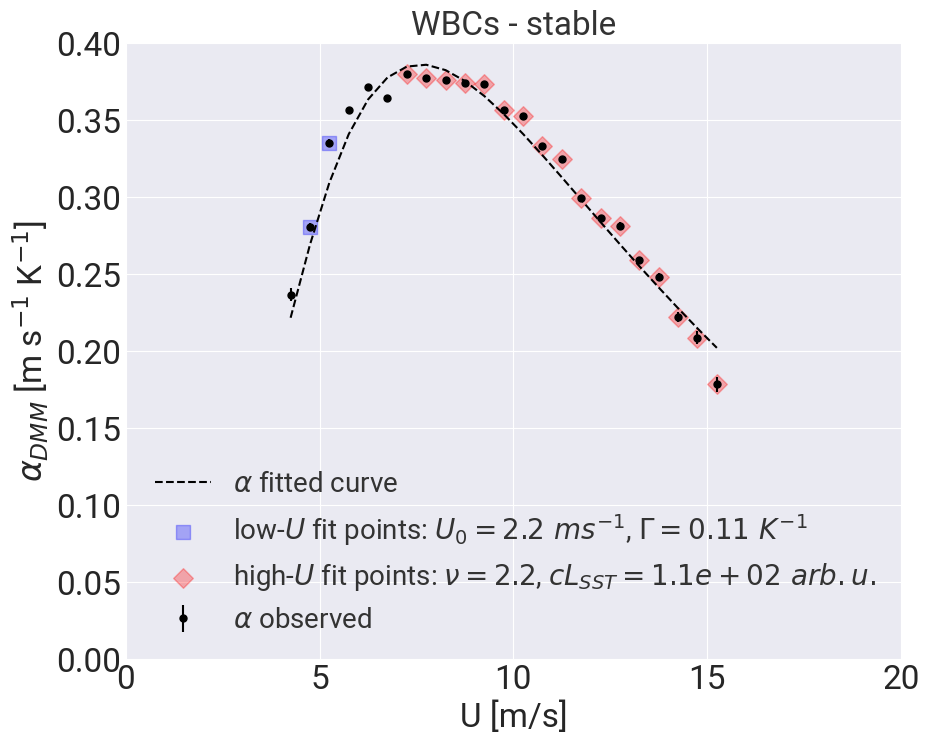

background_ws = (0.0, 0.5]
[0.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00 6.000e+00 1.500e+01
 7.100e+01 8.250e+02 2.606e+03 1.471e+03 1.832e+03 1.241e+03 3.290e+02
 1.020e+02 2.600e+01 1.000e+01 3.000e+00 2.000e+00 3.000e+00 0.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[0.000e+00 1.000e+00 2.000e+00 2.000e+00 1.400e+01 3.700e+01 6.900e+01
 3.190e+02 2.039e+03 6.304e+03 3.979e+03 5.128e+03 3.405e+03 7.600e+02
 1.950e+02 7.300e+01 1.600e+01 1.000e+01 6.000e+00 7.000e+00 3.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[0.0000e+00 1.0000e+00 3.0000e+00 8.0000e+00 2.2000e+01 4.0000e+01
 

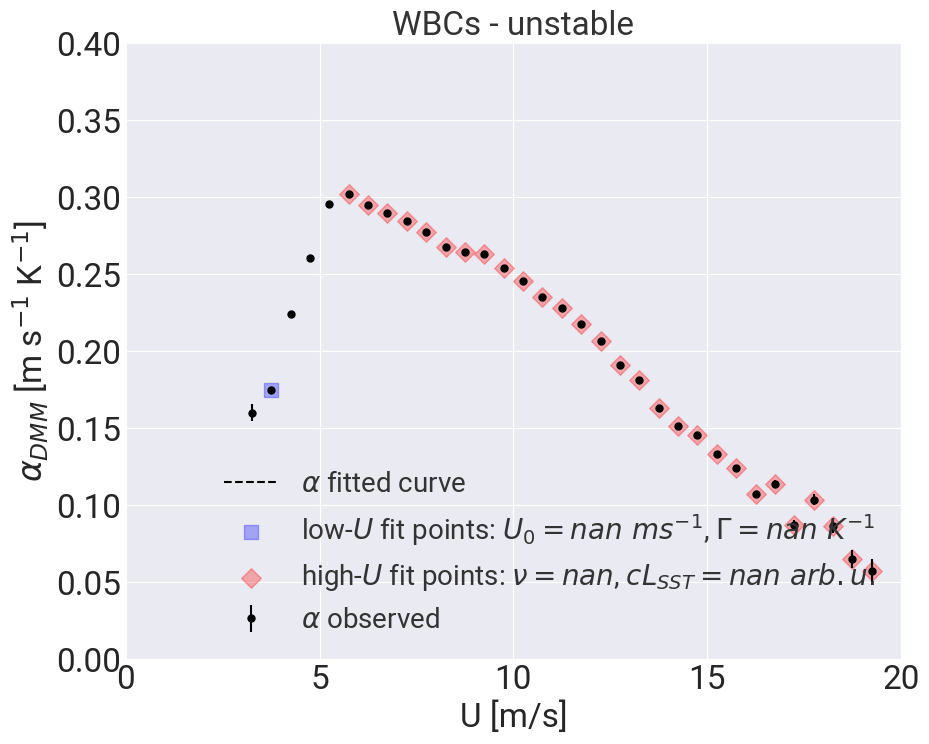

In [13]:
for atm_cond in ['stable','unstable']:

    # Select only the correct env cond
    if atm_cond == 'stable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left>=1])
    elif atm_cond == 'unstable': 
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left<=-1])

    env_cond = 'background_ws'

    # Define the containers for each tuple (coeff,background_ws_bin,log_L_bin,radius)
    coeff_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    env_cond_bin_ar = []
    coeff_p_value_ar = []
    coeff_err_ar = []
    intercept_err_ar = []
    n_points_ar = []
    # Goodness of fit
    q_ar = []

    # Is the bin populated by entries belonging to the same SAR scene?
    #uniform_bin_ar = []

    for env_cond_bin,group_by_env_cond_bin in binned_data_ds.groupby(env_cond):
        print(f"{env_cond} = {env_cond_bin}")

        # Compute the appropriate statistics for the current selection of data.
        # It is equivalent to project the 4 variables onto the env_cond axis.
        statistics_dict = dict()
        for statistic in group_by_env_cond_bin.data_vars:
            statistics_dict[statistic] = []
            for control_bin,group_ds in group_by_env_cond_bin.groupby('control'):
                statistics_dict[statistic].append(group_ds[statistic].sum().data)

        control_bin_ar = group_by_env_cond_bin['control'].data
        n_points_bin_ar = np.array(statistics_dict['n_points'])

        # Find which control bins have enough points to compute statistics
        enough_points_mask = [ n_points > min_n_points_control_bin  for n_points in n_points_bin_ar]
        # Check if there are enough control bins to perform the lin regr
        if sum(enough_points_mask) < min_n_control_bins:
            print(n_points_bin_ar)
            print(enough_points_mask)
            print(f"{env_cond} = {env_cond_bin} : not enough control bins")
            
            if False and enable_plot:
                if sum(enough_points_mask) == 0: continue
                # Compute control and response avg/errors and number of points for each control bin.
                n_points_bin_ar = n_points_bin_ar[enough_points_mask]
                mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
                mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
                err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]
                
            
                linreg_result = weighted_linear_regression_with_pvalues(
                mean_control_ar,
                mean_response_ar,
                err_response_ar
                )
                coeff = linreg_result['slope'][0]
                coeff_err = linreg_result['slope'][1]
                intercept = linreg_result['intercept'][0]
                intercept_err = linreg_result['intercept'][1]
                q = linreg_result['q']

                fig,ax = plt.subplots(figsize=(8,6)) 
                ax.errorbar(
                    mean_control_ar,
                    mean_response_ar, 
                    yerr=err_response_ar, 
                    fmt='rx',
                    )
                ax.set_xlabel(sst_deriv_label,fontsize=16)
                ax.set_ylabel(wind_deriv_label,fontsize=16)
                ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                ax.tick_params(axis='both', which='major', labelsize=14)
                
                # Add the lin regr for comparison
                # Calculate the corresponding y values
                y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                ax.plot(
                    mean_control_ar,
                    y_lin_regr,
                    label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                    color = 'red',
                    alpha = 0.5,
                )

                ax.legend()
                ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                ax.legend()
                plt.show()

            continue 
        
        # Compute control and response avg/errors and number of points for each control bin.
        n_points_bin_ar = n_points_bin_ar[enough_points_mask]
        mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
        mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
        err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]

        # In order to verify the linearity hp, we compute the naive linear regression
        # for positive and negative values of the control variable, and we
        # compare them. If they differ, then we plot the coupling curve and we reject
        # the env_cond_class
        if enable_pos_neg_lin_regr_test:
            print('Check linearity - pos/neg lin test')
            pos_mean_control_ar = [ c for c in mean_control_ar if c > 0]
            pos_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c > 0]
            neg_mean_control_ar = [ c for c in mean_control_ar if c < 0]
            neg_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c < 0]
            
            pos_naive_linreg_result = stats.linregress(
                pos_mean_control_ar,               
                pos_mean_response_ar
                )
            neg_naive_linreg_result = stats.linregress(
                neg_mean_control_ar,               
                neg_mean_response_ar
                )
            if pos_naive_linreg_result.slope*neg_naive_linreg_result.slope < 0:
                print(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} : Non-linear ')
                
                if False and enable_plot:
                    fig,ax = plt.subplots()            
                    ax.scatter(
                        pos_mean_control_ar,
                        pos_mean_response_ar, 
                        c='red',
                        )
                    ax.scatter(
                        neg_mean_control_ar,
                        neg_mean_response_ar, 
                        c='blue',
                        )
                    ax.set_xlabel(sst_deriv_label)
                    ax.set_ylabel(wind_deriv_label)
                    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}')
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    pos_y_lin_regr = np.multiply(pos_naive_linreg_result.slope*np.ones_like(pos_mean_control_ar),pos_mean_control_ar) + pos_naive_linreg_result.intercept*np.ones_like(pos_mean_control_ar)
                    ax.plot(
                        pos_mean_control_ar,
                        pos_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(pos_naive_linreg_result.slope)} ',
                        color = 'red',
                        alpha = 0.5,
                    )            
                    neg_y_lin_regr = np.multiply(neg_naive_linreg_result.slope*np.ones_like(neg_mean_control_ar),neg_mean_control_ar) + neg_naive_linreg_result.intercept*np.ones_like(neg_mean_control_ar)
                    ax.plot(
                        neg_mean_control_ar,
                        neg_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(neg_naive_linreg_result.slope)} ',
                        color = 'blue',
                        alpha = 0.5,
                    )
                    plt.show()
                continue


        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']


        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        naive_rvalue = naive_linreg_result.rvalue
            
        if enable_R_threshold:
            print(f'Check linearity - R^2 > {R_threshold}')
            if naive_rvalue**2 < R_threshold:
                print(f'Non-linear: reject R^2 = {naive_rvalue**2}')
                print(naive_linreg_result)
                if False and enable_plot:
                    fig,ax = plt.subplots(figsize=(8,6)) 
                    ax.errorbar(
                        mean_control_ar,
                        mean_response_ar, 
                        yerr=err_response_ar, 
                        fmt='rx',
                        )
                    ax.set_xlabel(sst_deriv_label,fontsize=16)
                    ax.set_ylabel(wind_deriv_label,fontsize=16)
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    ax.tick_params(axis='both', which='major', labelsize=14)
                    
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_lin_regr,
                        label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                        color = 'red',
                        alpha = 0.5,
                    )

                    y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_naive_lin_regr,
                        label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                        color = 'orange',
                        alpha = 0.5,
                    )
                    ax.legend()
                    
                    ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                    ax.legend()
                    plt.show()

                    if enable_save_coup_curve_figures:
                        raise NameError('Update')
                        fig.savefig(os.path.join(
                            coupling_coeff_output_folder,
                            f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                            bbox_inches="tight",
                            dpi=200
                            )
                    del fig,ax

                continue

        if False and enable_plot:
            fig,ax = plt.subplots(figsize=(8,6)) 
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                fmt='ro',
                )
            ax.set_xlabel(sst_deriv_label,fontsize=16)
            ax.set_ylabel(wind_deriv_label,fontsize=16)
            ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            ax.tick_params(axis='both', which='major', labelsize=14)
            
            # Add the lin regr for comparison
            # Calculate the corresponding y values
            y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_lin_regr,
                label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                color = 'red',
                alpha = 0.5,
            )

            y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_naive_lin_regr,
                label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                color = 'orange',
                alpha = 0.5,
            )
            ax.legend()
            
            ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
            ax.legend()
            plt.show()

            if enable_save_coup_curve_figures:
                raise NameError('Update')
                fig.savefig(os.path.join(
                    coupling_coeff_output_folder,
                    f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                    bbox_inches="tight",
                    dpi=200
                    )
            del fig,ax


        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        q_ar.append(q)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_bin_ar.append(env_cond_bin)
        n_points_ar.append(sum(n_points_bin_ar))

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            'coeff' : coeff_ar,
            'naive_coeff' : naive_coeff_ar,
            'coeff_err' : coeff_err_ar,
        #    'coeff_p_value' : coeff_p_value_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
            # 'sklearn_coeff' : sklearn_coeff_ar,
            env_cond+'_bin' : env_cond_bin_ar,
            'q' : q_ar,
            'n_points_bin' : n_points_ar,
        }
    )

    print('### Results ###')
    print(coupling_coeff_env_cond_distr_df)

    # Fit coupling coeff dependency on U
    U = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df['background_ws_bin']])
    U_peak_index = np.argmax(coupling_coeff_env_cond_distr_df['coeff'])
    
    if U[U_peak_index] != np.max(U[:U_peak_index+1]): raise NameError('Error in peak detection')
    if U[U_peak_index] != np.min(U[U_peak_index:]): raise NameError('Error in peak detection')

    ### Before peak, U -> 0 ###
    if area_config['area_str'] == 'wbcs':
        n_points_to_skip_low_U = 1

    coupling_coeff_env_cond_distr_df_low_U = coupling_coeff_env_cond_distr_df[n_points_to_skip_low_U:(U_peak_index+1)-n_points_to_discard_low_U]

    U_low = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_low_U['background_ws_bin']])
    coup_coeff_term = coupling_coeff_env_cond_distr_df_low_U['coeff']

    # "Force" fit through 0
    #U_low = np.insert(U_low,0,0)
    #coup_coeff_term = np.insert(coup_coeff_term,0,0)
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        U_low,               
        coup_coeff_term
    )
    
    Gamma = fit_result.slope
    alpha_0 = fit_result.intercept
    U_0 = -alpha_0/Gamma
    print(rf'$\Gamma = {Gamma}$, \alpha_0 = {alpha_0}, U_0 = {U_0}')
    

    ### After peak, U-> inf ###
    coupling_coeff_env_cond_distr_df_high_U = coupling_coeff_env_cond_distr_df[U_peak_index+n_points_to_discard_high_U:]

    U_high = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_high_U['background_ws_bin']])
    
    coup_coeff_term = np.log(-np.log(1-(coupling_coeff_env_cond_distr_df_high_U['coeff']-alpha_0)/(Gamma*U_high)))
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        np.log(U_high),               
        coup_coeff_term
    )
    print(f"\n\n\n high-U fit: {fit_result}")
    
    cL = np.exp(fit_result.intercept)
    nu = - fit_result.slope

    print(rf'cL = {cL}')
    print(rf'\nu = {nu}')

    # Final fit
    coup_coeff_fit = alpha_0 + np.multiply(Gamma*U,(1-np.exp(-cL*np.power(U,-nu))))
    coup_coeff_fit_2fold_L = alpha_0 + np.multiply(Gamma*U,(1-np.exp(-2*cL*np.power(U,-nu))))
    
    if True and enable_plot:
        fig,ax=plt.subplots(figsize=(10,8))

        # Data
        ax.errorbar(
            U,
            coupling_coeff_env_cond_distr_df.coeff,
            yerr = coupling_coeff_env_cond_distr_df.coeff_err,
            fmt = 'ko',
            ms=5,
            alpha = 1,
            label = rf'$\alpha$ observed',
            )
        
        # Full fit
        ax.plot(
            U,
            coup_coeff_fit,
            linestyle='--',
            color = 'black',
            label = rf'$\alpha$ fitted curve',
            )
        
        # 2fold L curve
        '''
        ax.plot(
            U,
            coup_coeff_fit_2fold_L,
            linestyle='--',
            color = 'grey',
            label = rf'fit $\alpha_{{{str_mech}}}$ 2-fold $L_{{SST}}$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$, $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(2*cL)}$',
            )
        '''
    
        # Low U fit
        '''
        U_low_fit = np.arange(2,6,0.5)
        ax.plot(
            U_low_fit,
            alpha_0 + Gamma*U_low_fit,
            linestyle='--',
            color = 'blue',
            label = rf'low-$U$ fit: $\alpha_{{{str_mech}}} = \alpha_0 + \Gamma \, U$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$',
            )
        '''

        # Plot points used in the low and high U fit
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_low_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_low_U.coeff,
            marker='s',
            s = 100,
            color='b',
            alpha = 0.3,
            label = rf'low-$U$ fit points: $U_0 = {"{:.2g}".format(U_0)}~ms^{{-1}}$, $\Gamma = {"{:.2g}".format(Gamma)}~K^{{-1}}$',
            )
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_high_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_high_U.coeff,
            marker='D',
            s=100,
            color='r',
            alpha = 0.3,
            label = rf'high-$U$ fit points: $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(cL)}~arb.u.$',
            )
        
        fontsize=24
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=fontsize)
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=fontsize)
        ax.set_xlim((0,20))
        ax.set_ylim((0,0.4))
        ax.grid(color='white')
        ax.set_ylabel(rf"$\alpha_{{{str_mech}}}$ {str_mech_unit}",fontsize=fontsize)
        ax.set_title(f"{area_config['area_name']} - {atm_cond}",fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize) 
        ax.legend(loc='lower right',fontsize=fontsize-4)


        if False:
            # Plot info on the intercept value
            # Define a small offset to apply to the x axis so they do not overlap.
            # The offset has to be dep on the env cond in the xaxis.
            # Let's take it as 5% of the avg bin distance
            #ax2_offset = np.mean([ np.mean(env_cond_bin.left-env_cond_bin.right) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values ])*0.1
            ax2 = ax.inset_axes([0, 0.8, 1, 0.20], sharex=ax)
            #ax2 = ax.twinx()
            ax2.errorbar(
        #        [ np.mean([env_cond_bin.right,env_cond_bin.left])+ax2_offset for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                coupling_coeff_env_cond_distr_df.intercept*1e5,
                yerr = coupling_coeff_env_cond_distr_df.intercept_err*1e5,
                color = 'purple',
                fmt = 's',
                alpha = 0.3,
                ms=5,
                #label = rf'$intercept_{{{str_mech}}}$',
                )
            #ax2.legend(loc="lower right")
            ax2.yaxis.tick_right()
            ax2.set_ylabel('y0 '+str_mech_unit+'*1e5',fontsize=10)
            ax2.yaxis.set_label_position('right')
            ax2.spines.top.set_visible(False)
            ax2.patch.set_alpha(0)

        plt.show()
        
        if enable_save_coup_coeff_figures:
            raise NameError('Update')
            fig.savefig(os.path.join(
                coupling_coeff_output_folder,
                f"coup_coeff_plot_{env_cond}_{database}_{file2read[:-4]}.png"),
                bbox_inches="tight",
                dpi=200
                )
        try: 
            del ax2,fig,ax
        except NameError:
            del fig,ax


    if enable_save_coup_coeff_data:
        print(f"Saving coupling coefficient {env_cond}")
        Path(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}').mkdir(parents=True, exist_ok=True)
        coupling_coeff_env_cond_distr_df.to_csv(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}'+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}_coup_coeff_vs_'+env_cond+'.txt')

## Plot for paper


background_ws = (0.0, 0.5]
[ 0.  0.  0.  2.  2.  0.  1.  8. 15. 51. 90. 31. 15.  2.  0.  0.  0.  0.
  0.  0.  0.  0.]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[  0.   0.   0.   0.   0.   4.   5.  10.  26. 114. 201. 169.  36.   8.
   0.   0.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[  0.   0.   0.   1.   4.   2.  12.  15. 154. 253. 397. 249.  98.  29.
   6.   1.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (1.0, 1.5] : not enoug

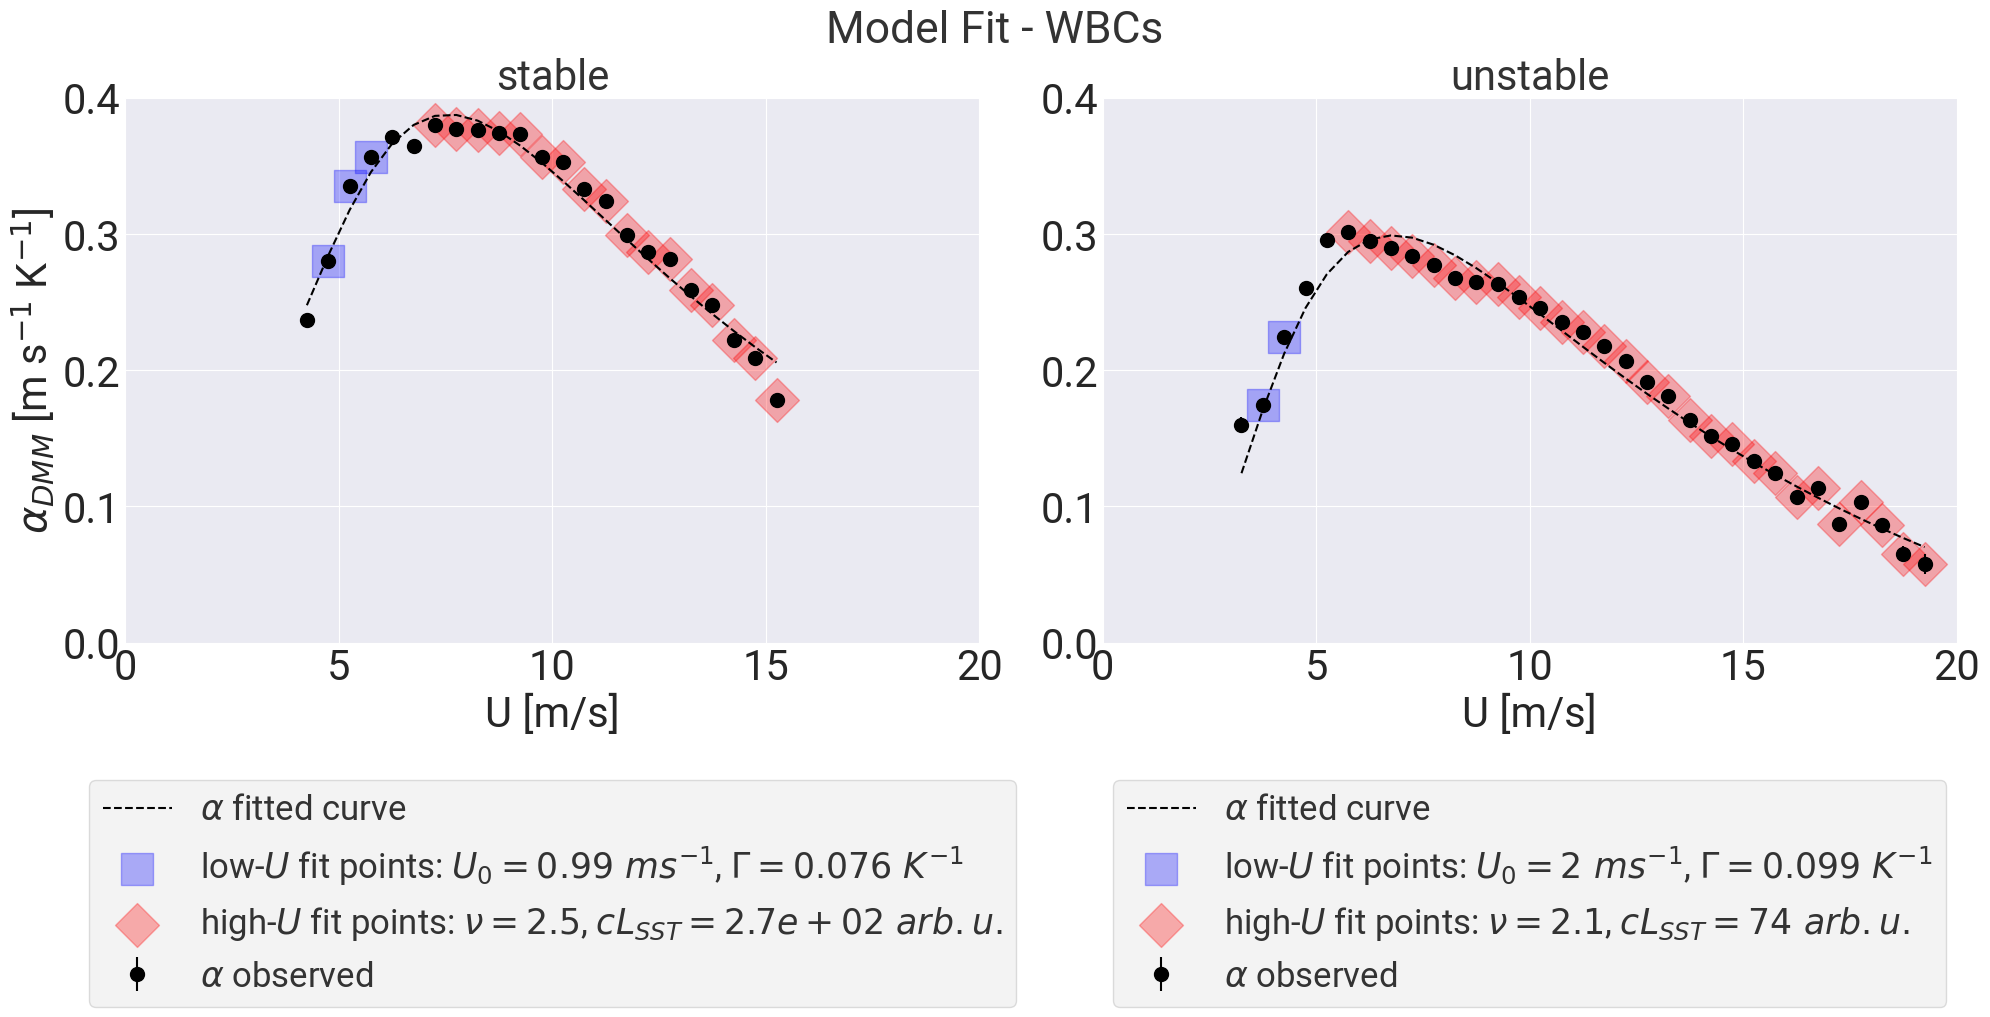

In [20]:
fig,axes = plt.subplots(1,2,figsize=(20,12))
fig.suptitle(f"Model Fit - {area_config['area_name']}",fontsize=fontsize+2)
fontsize = 30
markersize = 10
for atm_cond in ['stable','unstable']:

    # Select only the correct env cond
    if atm_cond == 'stable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left>=1])
        n_points_to_discard_low_U = 3
    elif atm_cond == 'unstable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left<=-1])
        n_points_to_discard_low_U = 3

    env_cond = 'background_ws'

    # Define the containers for each tuple (coeff,background_ws_bin,log_L_bin,radius)
    coeff_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    env_cond_bin_ar = []
    coeff_p_value_ar = []
    coeff_err_ar = []
    intercept_err_ar = []
    n_points_ar = []
    # Goodness of fit
    q_ar = []

    # Is the bin populated by entries belonging to the same SAR scene?
    #uniform_bin_ar = []

    for env_cond_bin,group_by_env_cond_bin in binned_data_ds.groupby(env_cond):
        print(f"{env_cond} = {env_cond_bin}")

        # Compute the appropriate statistics for the current selection of data.
        # It is equivalent to project the 4 variables onto the env_cond axis.
        statistics_dict = dict()
        for statistic in group_by_env_cond_bin.data_vars:
            statistics_dict[statistic] = []
            for control_bin,group_ds in group_by_env_cond_bin.groupby('control'):
                statistics_dict[statistic].append(group_ds[statistic].sum().data)

        control_bin_ar = group_by_env_cond_bin['control'].data
        n_points_bin_ar = np.array(statistics_dict['n_points'])

        # Find which control bins have enough points to compute statistics
        enough_points_mask = [ n_points > min_n_points_control_bin  for n_points in n_points_bin_ar]
        # Check if there are enough control bins to perform the lin regr
        if sum(enough_points_mask) < min_n_control_bins:
            print(n_points_bin_ar)
            print(enough_points_mask)
            print(f"{env_cond} = {env_cond_bin} : not enough control bins")
            
            if False and enable_plot:
                if sum(enough_points_mask) == 0: continue
                # Compute control and response avg/errors and number of points for each control bin.
                n_points_bin_ar = n_points_bin_ar[enough_points_mask]
                mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
                mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
                err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]
                
            
                linreg_result = weighted_linear_regression_with_pvalues(
                mean_control_ar,
                mean_response_ar,
                err_response_ar
                )
                coeff = linreg_result['slope'][0]
                coeff_err = linreg_result['slope'][1]
                intercept = linreg_result['intercept'][0]
                intercept_err = linreg_result['intercept'][1]
                q = linreg_result['q']

                fig,ax = plt.subplots(figsize=(8,6)) 
                ax.errorbar(
                    mean_control_ar,
                    mean_response_ar, 
                    yerr=err_response_ar, 
                    fmt='rx',
                    )
                ax.set_xlabel(sst_deriv_label,fontsize=16)
                ax.set_ylabel(wind_deriv_label,fontsize=16)
                ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                ax.tick_params(axis='both', which='major', labelsize=14)
                
                # Add the lin regr for comparison
                # Calculate the corresponding y values
                y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                ax.plot(
                    mean_control_ar,
                    y_lin_regr,
                    label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                    color = 'red',
                    alpha = 0.5,
                )

                ax.legend()
                ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                ax.legend()
                plt.show()

            continue 
        
        # Compute control and response avg/errors and number of points for each control bin.
        n_points_bin_ar = n_points_bin_ar[enough_points_mask]
        mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
        mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
        err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]

        # In order to verify the linearity hp, we compute the naive linear regression
        # for positive and negative values of the control variable, and we
        # compare them. If they differ, then we plot the coupling curve and we reject
        # the env_cond_class
        if enable_pos_neg_lin_regr_test:
            print('Check linearity - pos/neg lin test')
            pos_mean_control_ar = [ c for c in mean_control_ar if c > 0]
            pos_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c > 0]
            neg_mean_control_ar = [ c for c in mean_control_ar if c < 0]
            neg_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c < 0]
            
            pos_naive_linreg_result = stats.linregress(
                pos_mean_control_ar,               
                pos_mean_response_ar
                )
            neg_naive_linreg_result = stats.linregress(
                neg_mean_control_ar,               
                neg_mean_response_ar
                )
            if pos_naive_linreg_result.slope*neg_naive_linreg_result.slope < 0:
                print(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} : Non-linear ')
                
                if False and enable_plot:
                    fig,ax = plt.subplots()            
                    ax.scatter(
                        pos_mean_control_ar,
                        pos_mean_response_ar, 
                        c='red',
                        )
                    ax.scatter(
                        neg_mean_control_ar,
                        neg_mean_response_ar, 
                        c='blue',
                        )
                    ax.set_xlabel(sst_deriv_label)
                    ax.set_ylabel(wind_deriv_label)
                    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}')
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    pos_y_lin_regr = np.multiply(pos_naive_linreg_result.slope*np.ones_like(pos_mean_control_ar),pos_mean_control_ar) + pos_naive_linreg_result.intercept*np.ones_like(pos_mean_control_ar)
                    ax.plot(
                        pos_mean_control_ar,
                        pos_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(pos_naive_linreg_result.slope)} ',
                        color = 'red',
                        alpha = 0.5,
                    )            
                    neg_y_lin_regr = np.multiply(neg_naive_linreg_result.slope*np.ones_like(neg_mean_control_ar),neg_mean_control_ar) + neg_naive_linreg_result.intercept*np.ones_like(neg_mean_control_ar)
                    ax.plot(
                        neg_mean_control_ar,
                        neg_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(neg_naive_linreg_result.slope)} ',
                        color = 'blue',
                        alpha = 0.5,
                    )
                    plt.show()
                continue


        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']


        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        naive_rvalue = naive_linreg_result.rvalue
            
        if enable_R_threshold:
            print(f'Check linearity - R^2 > {R_threshold}')
            if naive_rvalue**2 < R_threshold:
                print(f'Non-linear: reject R^2 = {naive_rvalue**2}')
                print(naive_linreg_result)
                if False and enable_plot:
                    fig,ax = plt.subplots(figsize=(8,6)) 
                    ax.errorbar(
                        mean_control_ar,
                        mean_response_ar, 
                        yerr=err_response_ar, 
                        fmt='rx',
                        )
                    ax.set_xlabel(sst_deriv_label,fontsize=16)
                    ax.set_ylabel(wind_deriv_label,fontsize=16)
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    ax.tick_params(axis='both', which='major', labelsize=14)
                    
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_lin_regr,
                        label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                        color = 'red',
                        alpha = 0.5,
                    )

                    y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_naive_lin_regr,
                        label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                        color = 'orange',
                        alpha = 0.5,
                    )
                    ax.legend()
                    
                    ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                    ax.legend()
                    plt.show()

                    if enable_save_coup_curve_figures:
                        raise NameError('Update')
                        fig.savefig(os.path.join(
                            coupling_coeff_output_folder,
                            f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                            bbox_inches="tight",
                            dpi=200
                            )
                    del fig,ax

                continue

        if False and enable_plot:
            fig,ax = plt.subplots(figsize=(8,6)) 
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                fmt='ro',
                )
            ax.set_xlabel(sst_deriv_label,fontsize=16)
            ax.set_ylabel(wind_deriv_label,fontsize=16)
            ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            ax.tick_params(axis='both', which='major', labelsize=14)
            
            # Add the lin regr for comparison
            # Calculate the corresponding y values
            y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_lin_regr,
                label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                color = 'red',
                alpha = 0.5,
            )

            y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_naive_lin_regr,
                label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                color = 'orange',
                alpha = 0.5,
            )
            ax.legend()
            
            ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
            ax.legend()
            plt.show()

            if enable_save_coup_curve_figures:
                raise NameError('Update')
                fig.savefig(os.path.join(
                    coupling_coeff_output_folder,
                    f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                    bbox_inches="tight",
                    dpi=200
                    )
            del fig,ax


        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        q_ar.append(q)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_bin_ar.append(env_cond_bin)
        n_points_ar.append(sum(n_points_bin_ar))

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            'coeff' : coeff_ar,
            'naive_coeff' : naive_coeff_ar,
            'coeff_err' : coeff_err_ar,
        #    'coeff_p_value' : coeff_p_value_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
            # 'sklearn_coeff' : sklearn_coeff_ar,
            env_cond+'_bin' : env_cond_bin_ar,
            'q' : q_ar,
            'n_points_bin' : n_points_ar,
        }
    )

    print('### Results ###')
    print(coupling_coeff_env_cond_distr_df)

    # Fit coupling coeff dependency on U
    U = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df['background_ws_bin']])
    U_peak_index = np.argmax(coupling_coeff_env_cond_distr_df['coeff'])
    
    if U[U_peak_index] != np.max(U[:U_peak_index+1]): raise NameError('Error in peak detection')
    if U[U_peak_index] != np.min(U[U_peak_index:]): raise NameError('Error in peak detection')

    ### Before peak, U -> 0 ###
    if area_config['area_str'] == 'wbcs':
        n_points_to_skip_low_U = 1

    coupling_coeff_env_cond_distr_df_low_U = coupling_coeff_env_cond_distr_df[n_points_to_skip_low_U:(U_peak_index+1)-n_points_to_discard_low_U]

    U_low = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_low_U['background_ws_bin']])
    coup_coeff_term = coupling_coeff_env_cond_distr_df_low_U['coeff']

    # "Force" fit through 0
    #U_low = np.insert(U_low,0,0)
    #coup_coeff_term = np.insert(coup_coeff_term,0,0)
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        U_low,               
        coup_coeff_term
    )
    
    Gamma = fit_result.slope
    alpha_0 = fit_result.intercept
    U_0 = -alpha_0/Gamma
    print(rf'$\Gamma = {Gamma}$, \alpha_0 = {alpha_0}, U_0 = {U_0}')
    

    ### After peak, U-> inf ###
    coupling_coeff_env_cond_distr_df_high_U = coupling_coeff_env_cond_distr_df[U_peak_index+n_points_to_discard_high_U:]

    U_high = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_high_U['background_ws_bin']])
    
    coup_coeff_term = np.log(-np.log(1-(coupling_coeff_env_cond_distr_df_high_U['coeff']-alpha_0)/(Gamma*U_high)))
    
    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        np.log(U_high),               
        coup_coeff_term
    )
    print(f"\n\n\n high-U fit: {fit_result}")
    
    cL = np.exp(fit_result.intercept)
    nu = - fit_result.slope

    print(rf'cL = {cL}')
    print(rf'\nu = {nu}')

    # Final fit
    coup_coeff_fit = alpha_0 + np.multiply(Gamma*U,(1-np.exp(-cL*np.power(U,-nu))))
    coup_coeff_fit_2fold_L = alpha_0 + np.multiply(Gamma*U,(1-np.exp(-2*cL*np.power(U,-nu))))
    
    if True and enable_plot:
        #fig,ax=plt.subplots(figsize=(10,8))
        if atm_cond == 'stable':
            ax = axes[0]
        else:
            ax = axes[1]

        # Data
        ax.errorbar(
            U,
            coupling_coeff_env_cond_distr_df.coeff,
            yerr = coupling_coeff_env_cond_distr_df.coeff_err,
            fmt = 'ko',
            ms=markersize,
            alpha = 1,
            label = rf'$\alpha$ observed',
            )
        
        # Full fit
        ax.plot(
            U,
            coup_coeff_fit,
            linestyle='--',
            color = 'black',
            label = rf'$\alpha$ fitted curve',
            )
        
        # 2fold L curve
        '''
        ax.plot(
            U,
            coup_coeff_fit_2fold_L,
            linestyle='--',
            color = 'grey',
            label = rf'fit $\alpha_{{{str_mech}}}$ 2-fold $L_{{SST}}$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$, $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(2*cL)}$',
            )
        '''
    
        # Low U fit
        '''
        U_low_fit = np.arange(2,6,0.5)
        ax.plot(
            U_low_fit,
            alpha_0 + Gamma*U_low_fit,
            linestyle='--',
            color = 'blue',
            label = rf'low-$U$ fit: $\alpha_{{{str_mech}}} = \alpha_0 + \Gamma \, U$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$',
            )
        '''

        # Plot points used in the low and high U fit
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_low_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_low_U.coeff,
            marker='s',
            s = markersize*50,
            color='b',
            alpha = 0.3,
            label = rf'low-$U$ fit points: $U_0 = {"{:.2g}".format(U_0)}~ms^{{-1}}$, $\Gamma = {"{:.2g}".format(Gamma)}~K^{{-1}}$',
            )
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_high_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_high_U.coeff,
            marker='D',
            s=markersize*50,
            color='r',
            alpha = 0.3,
            label = rf'high-$U$ fit points: $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(cL)}~arb.u.$',
            )
        
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=fontsize)
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=fontsize)
        ax.set_xlim((0,20))
        ax.set_ylim((0,0.4))
        ax.grid(color='white')
        if atm_cond == 'stable':
            ax.set_ylabel(rf"$\alpha_{{{str_mech}}}$ {str_mech_unit}",fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize) 
        #ax.legend(loc='lower left',fontsize=fontsize-13)
        # Remove the current ax.legend(...) line and replace with:
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, -0.22),  # Move legend below the subplot
            fontsize=fontsize-5,
            ncol=1,  # Adjust as needed
            frameon=True,  # Show legend frame
            facecolor='#f0f0f0',  # Set legend background color
            edgecolor='lightgrey'        # Optional: set legend border color
        )

        # After the plotting loop, adjust the layout to make space for legends:
        plt.tight_layout(rect=[0, 0.15, 1, 1])  # Increase bottom margin as needed
        ax.set_title(f"{atm_cond}",fontsize=fontsize)


        if False:
            # Plot info on the intercept value
            # Define a small offset to apply to the x axis so they do not overlap.
            # The offset has to be dep on the env cond in the xaxis.
            # Let's take it as 5% of the avg bin distance
            #ax2_offset = np.mean([ np.mean(env_cond_bin.left-env_cond_bin.right) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values ])*0.1
            ax2 = ax.inset_axes([0, 0.8, 1, 0.20], sharex=ax)
            #ax2 = ax.twinx()
            ax2.errorbar(
        #        [ np.mean([env_cond_bin.right,env_cond_bin.left])+ax2_offset for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                coupling_coeff_env_cond_distr_df.intercept*1e5,
                yerr = coupling_coeff_env_cond_distr_df.intercept_err*1e5,
                color = 'purple',
                fmt = 's',
                alpha = 0.3,
                ms=5,
                #label = rf'$intercept_{{{str_mech}}}$',
                )
            #ax2.legend(loc="lower right")
            ax2.yaxis.tick_right()
            ax2.set_ylabel('y0 '+str_mech_unit+'*1e5',fontsize=10)
            ax2.yaxis.set_label_position('right')
            ax2.spines.top.set_visible(False)
            ax2.patch.set_alpha(0)
        
        if enable_save_coup_coeff_figures:
            raise NameError('Update')
            fig.savefig(os.path.join(
                coupling_coeff_output_folder,
                f"coup_coeff_plot_{env_cond}_{database}_{file2read[:-4]}.png"),
                bbox_inches="tight",
                dpi=200
                )
            
    if enable_save_coup_coeff_data:
        print(f"Saving coupling coefficient {env_cond}")
        Path(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}').mkdir(parents=True, exist_ok=True)
        coupling_coeff_env_cond_distr_df.to_csv(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}'+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}_coup_coeff_vs_'+env_cond+'.txt')

## $\alpha = a + b \cdot U \quad , \quad a = \alpha_0 \quad , \quad b = \Gamma \quad \text{for} \quad U \to 0$
## $ \alpha = \alpha_0 + \Gamma \, U (1-e^{\frac{c}{U^d}}) \quad, \quad c = c \, L_{SST} \quad , \quad d = \nu $

background_ws = (0.0, 0.5]
[ 0.  0.  0.  2.  2.  0.  1.  8. 15. 51. 90. 31. 15.  2.  0.  0.  0.  0.
  0.  0.  0.  0.]
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[  0.   0.   0.   0.   0.   4.   5.  10.  26. 114. 201. 169.  36.   8.
   0.   0.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[  0.   0.   0.   1.   4.   2.  12.  15. 154. 253. 397. 249.  98.  29.
   6.   1.   0.   0.   0.   0.   0.   0.]
[False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, False]
background_ws = (1.0, 1.5] : not enoug

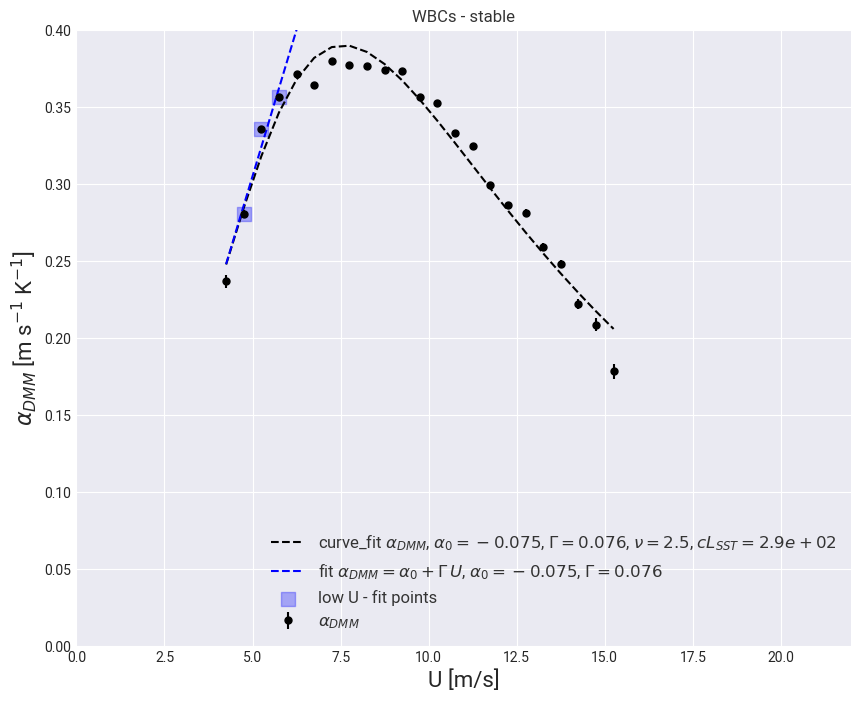

background_ws = (0.0, 0.5]
[0.000e+00 2.000e+00 0.000e+00 0.000e+00 7.000e+00 6.000e+00 1.500e+01
 7.100e+01 8.250e+02 2.606e+03 1.471e+03 1.832e+03 1.241e+03 3.290e+02
 1.020e+02 2.600e+01 1.000e+01 3.000e+00 2.000e+00 3.000e+00 0.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, False, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.0, 0.5] : not enough control bins
background_ws = (0.5, 1.0]
[0.000e+00 1.000e+00 2.000e+00 2.000e+00 1.400e+01 3.700e+01 6.900e+01
 3.190e+02 2.039e+03 6.304e+03 3.979e+03 5.128e+03 3.405e+03 7.600e+02
 1.950e+02 7.300e+01 1.600e+01 1.000e+01 6.000e+00 7.000e+00 3.000e+00
 0.000e+00]
[False, False, False, False, False, False, False, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False]
background_ws = (0.5, 1.0] : not enough control bins
background_ws = (1.0, 1.5]
[0.0000e+00 1.0000e+00 3.0000e+00 8.0000e+00 2.2000e+01 4.0000e+01
 

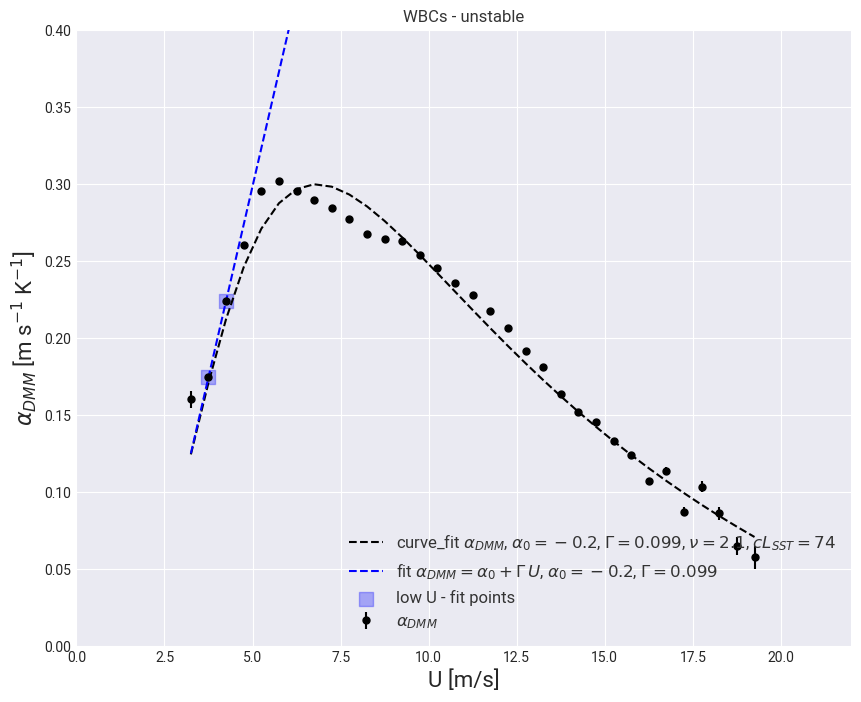

In [15]:
for atm_cond in ['stable','unstable']:

    # Select only the correct env cond
    if atm_cond == 'stable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left>=1])
    elif atm_cond == 'unstable':
        binned_data_ds = orig_binned_data_ds.sel(air_sea_temp_diff_era5 = [bin for bin in env_conds_classes['air_sea_temp_diff_era5']['bins'] if bin.left<=-1])

    env_cond = 'background_ws'

    # Define the containers for each tuple (coeff,background_ws_bin,log_L_bin,radius)
    coeff_ar = []
    naive_coeff_ar = []
    intercept_ar = []
    env_cond_bin_ar = []
    coeff_p_value_ar = []
    coeff_err_ar = []
    intercept_err_ar = []
    n_points_ar = []
    # Goodness of fit
    q_ar = []

    # Is the bin populated by entries belonging to the same SAR scene?
    #uniform_bin_ar = []

    for env_cond_bin,group_by_env_cond_bin in binned_data_ds.groupby(env_cond):
        print(f"{env_cond} = {env_cond_bin}")

        # Compute the appropriate statistics for the current selection of data.
        # It is equivalent to project the 4 variables onto the env_cond axis.
        statistics_dict = dict()
        for statistic in group_by_env_cond_bin.data_vars:
            statistics_dict[statistic] = []
            for control_bin,group_ds in group_by_env_cond_bin.groupby('control'):
                statistics_dict[statistic].append(group_ds[statistic].sum().data)

        control_bin_ar = group_by_env_cond_bin['control'].data
        n_points_bin_ar = np.array(statistics_dict['n_points'])

        # Find which control bins have enough points to compute statistics
        enough_points_mask = [ n_points > min_n_points_control_bin  for n_points in n_points_bin_ar]
        # Check if there are enough control bins to perform the lin regr
        if sum(enough_points_mask) < min_n_control_bins:
            print(n_points_bin_ar)
            print(enough_points_mask)
            print(f"{env_cond} = {env_cond_bin} : not enough control bins")
            
            if False and enable_plot:
                if sum(enough_points_mask) == 0: continue
                # Compute control and response avg/errors and number of points for each control bin.
                n_points_bin_ar = n_points_bin_ar[enough_points_mask]
                mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
                mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
                err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]
                
            
                linreg_result = weighted_linear_regression_with_pvalues(
                mean_control_ar,
                mean_response_ar,
                err_response_ar
                )
                coeff = linreg_result['slope'][0]
                coeff_err = linreg_result['slope'][1]
                intercept = linreg_result['intercept'][0]
                intercept_err = linreg_result['intercept'][1]
                q = linreg_result['q']

                fig,ax = plt.subplots(figsize=(8,6)) 
                ax.errorbar(
                    mean_control_ar,
                    mean_response_ar, 
                    yerr=err_response_ar, 
                    fmt='rx',
                    )
                ax.set_xlabel(sst_deriv_label,fontsize=16)
                ax.set_ylabel(wind_deriv_label,fontsize=16)
                ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                ax.tick_params(axis='both', which='major', labelsize=14)
                
                # Add the lin regr for comparison
                # Calculate the corresponding y values
                y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                ax.plot(
                    mean_control_ar,
                    y_lin_regr,
                    label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                    color = 'red',
                    alpha = 0.5,
                )

                ax.legend()
                ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                ax.legend()
                plt.show()

            continue 
        
        # Compute control and response avg/errors and number of points for each control bin.
        n_points_bin_ar = n_points_bin_ar[enough_points_mask]
        mean_control_ar = np.divide(statistics_dict['sum_control'],statistics_dict['n_points'])[enough_points_mask]
        mean_response_ar = np.divide(statistics_dict['sum_response'],statistics_dict['n_points'])[enough_points_mask]
        err_response_ar = np.sqrt(np.divide(statistics_dict['sum_response_pow2']-np.divide(np.power(statistics_dict['sum_response'],2),statistics_dict['n_points']),np.power(statistics_dict['n_points'],2)))[enough_points_mask]

        # In order to verify the linearity hp, we compute the naive linear regression
        # for positive and negative values of the control variable, and we
        # compare them. If they differ, then we plot the coupling curve and we reject
        # the env_cond_class
        if enable_pos_neg_lin_regr_test:
            print('Check linearity - pos/neg lin test')
            pos_mean_control_ar = [ c for c in mean_control_ar if c > 0]
            pos_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c > 0]
            neg_mean_control_ar = [ c for c in mean_control_ar if c < 0]
            neg_mean_response_ar = [r for c, r in zip(mean_control_ar, mean_response_ar) if c < 0]
            
            pos_naive_linreg_result = stats.linregress(
                pos_mean_control_ar,               
                pos_mean_response_ar
                )
            neg_naive_linreg_result = stats.linregress(
                neg_mean_control_ar,               
                neg_mean_response_ar
                )
            if pos_naive_linreg_result.slope*neg_naive_linreg_result.slope < 0:
                print(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} : Non-linear ')
                
                if False and enable_plot:
                    fig,ax = plt.subplots()            
                    ax.scatter(
                        pos_mean_control_ar,
                        pos_mean_response_ar, 
                        c='red',
                        )
                    ax.scatter(
                        neg_mean_control_ar,
                        neg_mean_response_ar, 
                        c='blue',
                        )
                    ax.set_xlabel(sst_deriv_label)
                    ax.set_ylabel(wind_deriv_label)
                    ax.set_title(f'{env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]}')
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    pos_y_lin_regr = np.multiply(pos_naive_linreg_result.slope*np.ones_like(pos_mean_control_ar),pos_mean_control_ar) + pos_naive_linreg_result.intercept*np.ones_like(pos_mean_control_ar)
                    ax.plot(
                        pos_mean_control_ar,
                        pos_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(pos_naive_linreg_result.slope)} ',
                        color = 'red',
                        alpha = 0.5,
                    )            
                    neg_y_lin_regr = np.multiply(neg_naive_linreg_result.slope*np.ones_like(neg_mean_control_ar),neg_mean_control_ar) + neg_naive_linreg_result.intercept*np.ones_like(neg_mean_control_ar)
                    ax.plot(
                        neg_mean_control_ar,
                        neg_y_lin_regr,
                        label = f'linear regression, slope = {"{:.1e}".format(neg_naive_linreg_result.slope)} ',
                        color = 'blue',
                        alpha = 0.5,
                    )
                    plt.show()
                continue


        # Take into account uncertainties in lin regr
        linreg_result = weighted_linear_regression_with_pvalues(
            mean_control_ar,
            mean_response_ar,
            err_response_ar
        )
        coeff = linreg_result['slope'][0]
        coeff_err = linreg_result['slope'][1]
        intercept = linreg_result['intercept'][0]
        intercept_err = linreg_result['intercept'][1]
        q = linreg_result['q']


        # Compute coeff with a simple linear fit
        naive_linreg_result = stats.linregress(
            mean_control_ar,               
            mean_response_ar
            )
        naive_coeff = naive_linreg_result.slope
        naive_intercept = naive_linreg_result.intercept
        naive_rvalue = naive_linreg_result.rvalue
            
        if enable_R_threshold:
            print(f'Check linearity - R^2 > {R_threshold}')
            if naive_rvalue**2 < R_threshold:
                print(f'Non-linear: reject R^2 = {naive_rvalue**2}')
                print(naive_linreg_result)
                if False and enable_plot:
                    fig,ax = plt.subplots(figsize=(8,6)) 
                    ax.errorbar(
                        mean_control_ar,
                        mean_response_ar, 
                        yerr=err_response_ar, 
                        fmt='rx',
                        )
                    ax.set_xlabel(sst_deriv_label,fontsize=16)
                    ax.set_ylabel(wind_deriv_label,fontsize=16)
                    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
                    ax.tick_params(axis='both', which='major', labelsize=14)
                    
                    # Add the lin regr for comparison
                    # Calculate the corresponding y values
                    y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_lin_regr,
                        label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                        color = 'red',
                        alpha = 0.5,
                    )

                    y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
                    ax.plot(
                        mean_control_ar,
                        y_naive_lin_regr,
                        label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                        color = 'orange',
                        alpha = 0.5,
                    )
                    ax.legend()
                    
                    ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
                    ax.legend()
                    plt.show()

                    if enable_save_coup_curve_figures:
                        raise NameError('Update')
                        fig.savefig(os.path.join(
                            coupling_coeff_output_folder,
                            f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                            bbox_inches="tight",
                            dpi=200
                            )
                    del fig,ax

                continue

        if False and enable_plot:
            fig,ax = plt.subplots(figsize=(8,6)) 
            ax.errorbar(
                mean_control_ar,
                mean_response_ar, 
                yerr=err_response_ar, 
                fmt='ro',
                )
            ax.set_xlabel(sst_deriv_label,fontsize=16)
            ax.set_ylabel(wind_deriv_label,fontsize=16)
            ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            ax.tick_params(axis='both', which='major', labelsize=14)
            
            # Add the lin regr for comparison
            # Calculate the corresponding y values
            y_lin_regr = np.multiply(coeff*np.ones_like(mean_control_ar),mean_control_ar) + intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_lin_regr,
                label = rf'weighted linear regression, $\alpha_{{DDM}}$ = {"{:.1e}".format(coeff)} ',
                color = 'red',
                alpha = 0.5,
            )

            y_naive_lin_regr = np.multiply(naive_coeff*np.ones_like(mean_control_ar),mean_control_ar) + naive_intercept*np.ones_like(mean_control_ar)
            ax.plot(
                mean_control_ar,
                y_naive_lin_regr,
                label = f'naive linear regression, slope = {"{:.1e}".format(naive_coeff)}',
                color = 'orange',
                alpha = 0.5,
            )
            ax.legend()
            
            ax.set_title(f'{area_config['area_name']} - {env_conds_plot_attrs[env_cond]['axis_label']} = {round((env_cond_bin.right+env_cond_bin.left)/2,2)} {env_conds_plot_attrs[env_cond]['unit'][1:-1]} - MetOp')
            ax.legend()
            plt.show()

            if enable_save_coup_curve_figures:
                raise NameError('Update')
                fig.savefig(os.path.join(
                    coupling_coeff_output_folder,
                    f"coup_curve_plot_{env_cond}_{round((env_cond_bin.right+env_cond_bin.left)/2,1)}_glona_{file2read[:-4]}.png"),
                    bbox_inches="tight",
                    dpi=200
                    )
            del fig,ax


        # Save infor on current env cond
        coeff_ar.append(coeff)
        naive_coeff_ar.append(naive_coeff)
        coeff_err_ar.append(coeff_err)
        q_ar.append(q)
        intercept_ar.append(intercept)
        intercept_err_ar.append(intercept_err)
        env_cond_bin_ar.append(env_cond_bin)
        n_points_ar.append(sum(n_points_bin_ar))

    coupling_coeff_env_cond_distr_df = pd.DataFrame.from_dict(
        {
            'coeff' : coeff_ar,
            'naive_coeff' : naive_coeff_ar,
            'coeff_err' : coeff_err_ar,
        #    'coeff_p_value' : coeff_p_value_ar,
            'intercept' : intercept_ar,
            'intercept_err' : intercept_err_ar,
            # 'sklearn_coeff' : sklearn_coeff_ar,
            env_cond+'_bin' : env_cond_bin_ar,
            'q' : q_ar,
            'n_points_bin' : n_points_ar,
        }
    )

    print('### Results ###')
    print(coupling_coeff_env_cond_distr_df)

    # Fit coupling coeff dependency on U
    U = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df['background_ws_bin']])
    
    ### Before peak, U -> 0 ###
    U_peak_index = np.argmax(coupling_coeff_env_cond_distr_df['coeff'])

    if U[U_peak_index] != np.max(U[:U_peak_index+1]): raise NameError('Error in peak detection')
    if U[U_peak_index] != np.min(U[U_peak_index:]): raise NameError('Error in peak detection')

    coupling_coeff_env_cond_distr_df_low_U = coupling_coeff_env_cond_distr_df[n_points_to_skip_low_U:(U_peak_index+1)-n_points_to_discard_low_U]
    U_low = np.array([np.mean((ws_bin.right,ws_bin.left)) for ws_bin in coupling_coeff_env_cond_distr_df_low_U['background_ws_bin']])
    coup_coeff_term = coupling_coeff_env_cond_distr_df_low_U['coeff']

    if len(coup_coeff_term) == 0:
        continue
    fit_result = stats.linregress(
        U_low,               
        coup_coeff_term
    )
    
    Gamma = fit_result.slope
    alpha_0 = fit_result.intercept
    
    
    ### Curve_fit whole range
    coup_coeff_term = coupling_coeff_env_cond_distr_df['coeff']
    fit_func = lambda U,cL,nu : alpha_0 + np.multiply(Gamma*U,(1-np.exp(-cL*np.power(U,-nu))))
    
    if len(coup_coeff_term) < 4:
        print(f"Not enough points - {atm_cond}")
        continue

    popt,pcov = optimize.curve_fit(
        fit_func,
        U,
        coup_coeff_term,
    )
    
    cL = popt[0]
    nu = popt[1]

    # Final fit
    coup_coeff_fit = alpha_0 + np.multiply(Gamma*U,(1-np.exp(-cL*np.power(U,-nu))))
    
    if True and enable_plot:
        fig,ax=plt.subplots(figsize=(10,8))

        # Data
        ax.errorbar(
            U,
            coupling_coeff_env_cond_distr_df.coeff,
            yerr = coupling_coeff_env_cond_distr_df.coeff_err,
            fmt = 'ko',
            ms=5,
            alpha = 1,
            label = rf'$\alpha_{{{str_mech}}}$',
            )
        
        # Full fit
        ax.plot(
            U,
            coup_coeff_fit,
            linestyle='--',
            color = 'black',
            label = rf'curve_fit $\alpha_{{{str_mech}}}$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$, $\nu = {"{:.2g}".format(nu)}$, $cL_{{SST}} = {"{:.2g}".format(cL)}$',
            )
        
        # Low U fit
        ax.plot(
            U,
            alpha_0 + Gamma*U,
            linestyle='--',
            color = 'blue',
            label = rf'fit $\alpha_{{{str_mech}}} = \alpha_0 + \Gamma \, U$, $\alpha_0 = {"{:.2g}".format(alpha_0)}$, $\Gamma = {"{:.2g}".format(Gamma)}$',
            )
        
        # Plot points used in the low and high U fit
        ax.scatter(
            [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df_low_U[env_cond+'_bin'].values],
            coupling_coeff_env_cond_distr_df_low_U.coeff,
            marker='s',
            s = 100,
            color='b',
            alpha = 0.3,
            label = 'low U - fit points',
            )
        
        
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=16)
        ax.set_xlabel(rf'{env_conds_plot_attrs[env_cond]['axis_label']} {env_conds_plot_attrs[env_cond]['unit']}',fontsize=16)
        ax.set_xlim((0,22))
        ax.set_ylim((0,lim_coupl_coeff))
        ax.grid(color='white')
        ax.set_ylabel(rf"$\alpha_{{{str_mech}}}$ {str_mech_unit}",fontsize=16)
        ax.set_title(f"{area_config['area_name']} - {atm_cond}")
        ax.legend(loc='lower right',fontsize=12)


        if False:
            # Plot info on the intercept value
            # Define a small offset to apply to the x axis so they do not overlap.
            # The offset has to be dep on the env cond in the xaxis.
            # Let's take it as 5% of the avg bin distance
            #ax2_offset = np.mean([ np.mean(env_cond_bin.left-env_cond_bin.right) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values ])*0.1
            ax2 = ax.inset_axes([0, 0.8, 1, 0.20], sharex=ax)
            #ax2 = ax.twinx()
            ax2.errorbar(
        #        [ np.mean([env_cond_bin.right,env_cond_bin.left])+ax2_offset for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                [ np.mean([env_cond_bin.right,env_cond_bin.left]) for env_cond_bin in coupling_coeff_env_cond_distr_df[env_cond+'_bin'].values],
                coupling_coeff_env_cond_distr_df.intercept*1e5,
                yerr = coupling_coeff_env_cond_distr_df.intercept_err*1e5,
                color = 'purple',
                fmt = 's',
                alpha = 0.3,
                ms=5,
                #label = rf'$intercept_{{{str_mech}}}$',
                )
            #ax2.legend(loc="lower right")
            ax2.yaxis.tick_right()
            ax2.set_ylabel('y0 '+str_mech_unit+'*1e5',fontsize=10)
            ax2.yaxis.set_label_position('right')
            ax2.spines.top.set_visible(False)
            ax2.patch.set_alpha(0)

        plt.show()
        
        if enable_save_coup_coeff_figures:
            raise NameError('Update')
            fig.savefig(os.path.join(
                coupling_coeff_output_folder,
                f"coup_coeff_plot_{env_cond}_{database}_{file2read[:-4]}.png"),
                bbox_inches="tight",
                dpi=200
                )
        try: 
            del ax2,fig,ax
        except NameError:
            del fig,ax


    if enable_save_coup_coeff_data:
        print(f"Saving coupling coefficient {env_cond}")
        Path(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}').mkdir(parents=True, exist_ok=True)
        coupling_coeff_env_cond_distr_df.to_csv(coupling_coeff_output_folder+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}'+f'/{os.path.basename(files[0])[:-41]}{period_start}_to_{period_end}_sigma{sigma}_psi{psi}_perc_bins_{enable_percentile_control_bins}_coup_coeff_vs_'+env_cond+'.txt')